In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from utils import sample_PLN
import scipy.linalg as SLA
import torch.linalg as TLA
import scipy
from fastPLN import fastPLN
from scipy.special import factorial
import math
import seaborn as sns 
import torch 
from pandas import read_csv
import math
import time
import scipy.integrate as integrate 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from fastPLN import fastPLN
import threading
from tqdm import tqdm
#torch.set_default_dtype(torch.float64)
from sklearn.linear_model import LinearRegression
import concurrent.futures

device :  cpu


In [2]:
device = torch.device('cpu')

In [3]:
torch.__version__

'1.9.0+cu102'

In [4]:
%load_ext autoreload

%autoreload 2

### Implementation

We first define some functions that will help implement and visualize the model. 

In [5]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    np.random.seed(0)
    alea = np.random.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = np.zeros((p,p))
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*toeplitz(0.7**np.arange(block_size))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*toeplitz(0.7**np.arange(last_block_size))
    return Sigma+0.1*toeplitz(0.95**np.arange(p))


def C_from_Sigma(Sigma,q): 
    ''' 
    get the best matrix of size (p,q) when Sigma is of size (p,p). i.e. reduces norm(Sigma-C@C.T)
    args : 
        Sigma : np.array of size (p,p). Should be positive definite and symmetric.
        q : int. The number of columns you want in your matrix C. 
        
    returns : C_reduct : np.array of size (p,q) that contains the q eigenvectors with largest eigenvalues. 
    '''
    w,v = SLA.eigh(Sigma)
    C_reduct = v[:,-q:]@np.diag(np.sqrt(w[-q:]))
    return C_reduct

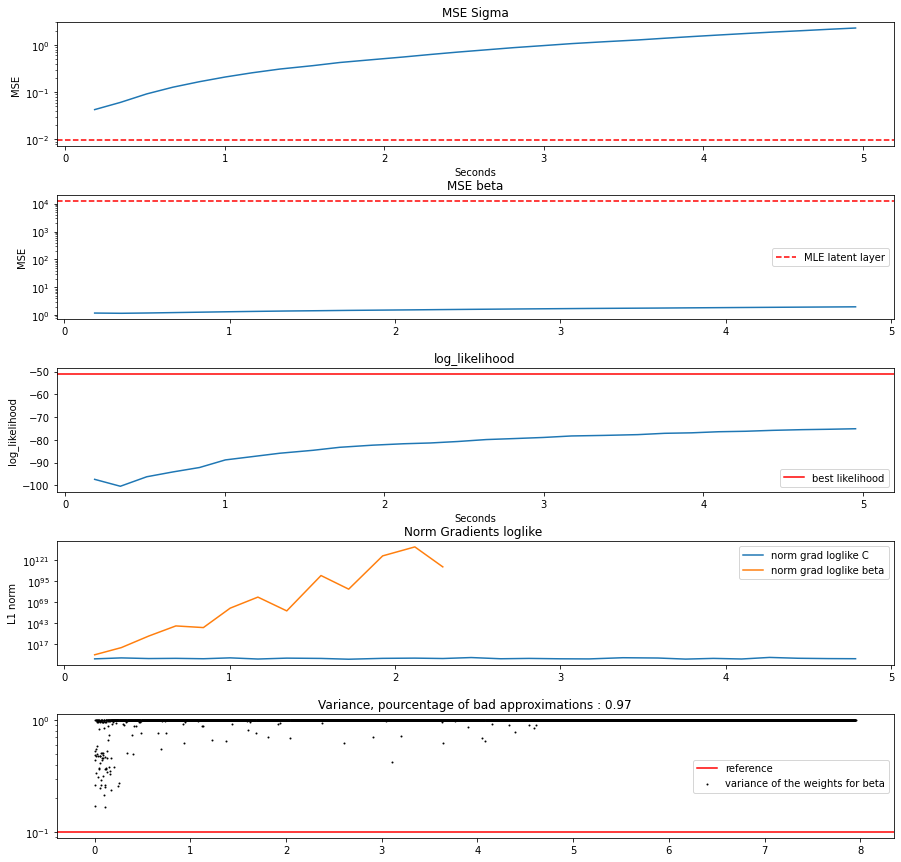

In [79]:

    
def compare_models(dict_models,name_doss, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model (MC_PLNPCA object where you
                      have called model.fit_IMPS()).
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    best_model = MC_PLNPCA(q, batch_size, true_value = True)
    best_model.init_data(Y_sampled, O, covariates)
    #get the max of all the likelihoods for a nice plot. We intialize the max with the likelihood of the 
    # model that has the true parameters (unknown in practice) 
    best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    max_ = best_log_like
    for name,model in dict_models.items():
        current_max = np.max(np.array(model.log_likelihood_list))
        max_ = max(max_,current_max)
    fig,ax = plt.subplots(3,1,figsize = (15,15))
    
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ')
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer')
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        
        #ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        #ax[0].set_yticks()
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        
        #ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        
        
        
        
        ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_, label = name )
        ax[2].legend()
        ax[2].set_title('log_likelihood')
        ax[2].set_ylabel('log_likelihood')
        ax[2].set_yscale('symlog')
        #ax[2].set_xlabel('Seconds')
    
    ax[2].axhline(np.array(best_log_like)-max_, c = 'red', label = 'best likelihood')
    plt.suptitle(name_doss)
    if save : 
        plt.savefig(name_doss)
    plt.show()
    

def show(model,name_doss , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    best_model = MC_PLNPCA(q, batch_size, true_value = True)
    best_model.init_data(Y_sampled, O, covariates)
    fig,ax = plt.subplots(5,1,figsize = (15,15))
    
    
        
    d = model.beta.shape[0]
    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title('MSE Sigma')
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ', c = 'red', linestyle = '--')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylabel('MSE')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title('MSE beta') 
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer', c = 'red', linestyle = '--')
    #ax[1].set_xlabel('Seconds')
    ax[1].set_ylabel('MSE')
    ax[1].set_yscale('log')
    ax[1].legend()
    #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
    length = len(abscisse)
    ax[2].plot(abscisse, model.log_likelihood_list)
    ax[2].set_title('log_likelihood')
    ax[2].set_ylabel('log_likelihood')
    ax[2].set_xlabel('Seconds')
    best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
    #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
    ax[2].axhline(best_log_like, c = 'red', label = 'best likelihood')
    ax[2].legend()
    # plot the L1 norm of the gradients. 
    ax[3].plot(abscisse, model.norm_grad_log_C_list, label = 'norm grad loglike C')
    ax[3].plot(abscisse, model.norm_grad_log_beta_list, label = 'norm grad loglike beta')
    ax[3].set_title('Norm Gradients loglike ')
    ax[3].set_ylabel('L1 norm')
    ax[3].set_yscale('log')
    ax[3].legend()
    
    #print('var', model.var_arr)
    if model.var_weights_bis.shape[0] == 0 : 
        ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['beta'].shape[0]), model.var_weights['beta'],s = 1, label = 'variance of the weights for beta', c = 'black')
        percentage_bad = np.sum(model.var_weights['beta']>0.995)/(model.var_weights['beta'].shape[0])
        #ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['C_exp'].shape[0]), model.var_weights['C_exp'],s = 1, label = 'variance of the weights for C_exp')
        #ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['C_W'].shape[0]), model.var_weights['C_W'],s = 1, label = 'variance of the weights for W', c = 'red')
    else : 
        percentage_bad = np.sum(model.var_weights_bis>0.995)/(model.var_weights_bis.shape[0])
        ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights_bis.shape[0]), model.var_weights_bis,s = 1, label = 'variance of the weights')
    ax[4].axhline(model.acc, c = 'red', label = 'reference')
    ax[4].set_title('Variance, pourcentage of bad approximations : '+ str(np.round(percentage_bad,3)))
    ax[4].set_yscale('log')
    ax[4].legend()

    
    if save : 
        plt.savefig(name_doss)
    plt.show()
        

show(model, '', save = False)




In [74]:
#compare_models(dict_lrs,'',save = False)

In [8]:
def find_best_lr(optimizer,N_iter, acc, lrs, q, batch_size, average):
    '''
    function that is supposed to find the best lr within a grid of lr (lrs) for 
    an optimizer to fit the MC_PLNPCA method. the metric used
    to discriminate each lr is the sum of MSE_beta and MSE_Sigma. A more logic one would be the log likelihood
    but I can't implement this right now. We parallelized the code to go faster. 
    
    args: otpimizer : should be an object of torch.optim., for example torch.optim.Rprop. 
    
        N_iter : int. The number of iterations you want to do when running the .fit_IMPS method.
    
        acc : float positive. the accuracy you want when running the .fit_IMPS method. 
        
        lrs : lis. the grid of lr.
        
        q : the dimension q you want for the model. 
        
        batch_size : int. The batch_size you want  when running the .fit_IMPS method.
        
        average : int. the average argument for the model. 
        
    returns : the best lr according to the metric
    '''
    #initiate some lists. 
    metrics = list()
    models = list()
    ts = list()
    # launch the models with the right lr. 
    for lr in lrs: 
        model = MC_PLNPCA(q,batch_size, average = average, no_mean= True)
        t = threading.Thread(target =model.fit_IMPS,
                             args = [Y_sampled, O,covariates, N_iter          ,acc, lr     , optimizer] )
        #t =threading.Thread(target = model.fit_torch,
              
        t.start()
        ts.append(t)
        models.append(model)
        
    # join each threading. 
    for t in ts: 
        t.join()
    # get the metrics for each model. 
    other = []
    for i, model in enumerate(models) :
        other.append(np.mean(np.array(model.MSE_beta_list)) + np.mean(np.array(model.MSE_Sigma_list)))
        metrics.append(np.mean(np.array(model.log_likelihood_list)))
    #print('metrics', metrics)
    #print('other',other)
    metrics = np.nan_to_num(np.array(metrics),-100000)
    argmax = np.argmax(metrics)#argmin of the metrics 
    best_lr = lrs[argmax]
#     show(models[argmin],'',save = False)
    return best_lr, dict(zip(lrs,models)), models[argmax]  #the best lr. 

lrs = [0.001,0.01, 0.02,0.03, 0.1,0.2,0.3]#0.5,1.]#,1.2,1.5,2]
%time best_lr,dict_lrs,best_model = find_best_lr(torch.optim.Adamax, 15, 0.1,lrs, q , batch_size , average = n)

NameError: name 'q' is not defined

In [9]:
print('best_lr', best_lr)

NameError: name 'best_lr' is not defined

In [ ]:
compare_models(dict_lrs,'')

In [ ]:
def launch_optimizers_and_lrs(dict_optimizers,N_iter,N_iter_test, acc, q,batch_size):
    '''
    launch some optimizers to fit the .fit_IMPS method of the MC_PLNPCA object to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         acc : positive float. the accuracy you want when running the .fit_IMPS method. 
         
         lr : float. the learning rate of each optimizer.
    
         q : int. the dimension you want for the MC_PLNPCA object. 
         
         batch_size : int. the batch_size you want. 
         
    return : a dict of model. The key are the name of the optimizer, the values are the models trained with 
            the corresponding optimizer. 
    '''
    
    models = list()
    lrs = [0.001,0.01, 0.02,0.03, 0.1,0.2,0.3,0.5]
    ts_lr = list()
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        params = []
        for name,optimizer in dict_optimizers.items(): 
            params.append([optimizer, N_iter_test,acc,lrs, q,batch_size ,n//4])
        #did not have the choice to do this since I need to get the returned value back. 
        futures = [executor.submit(find_best_lr, param[0],param[1],param[2],param[3],param[4],param[5],param[6]) for param in params]
        best_lrs = [f.result()[0] for f in futures]
    
    del futures
    print('best_lrs ', best_lrs)
    ts = list()    
    # lauch all the model with the right optimizer in a parallelized fashion. 
    
    for i, (name, optimizer) in enumerate(dict_optimizers.items()): 
        model = MC_PLNPCA(q,batch_size)
        print(' lr chosen : ', best_lrs[i], ' for the optimizer ', optimizer)
        t = threading.Thread(target =model.fit_IMPS,
              args = [Y_sampled, O,covariates, N_iter          ,acc, best_lrs[i]     , optimizer] )
        t.start()
        ts.append(t)
        models.append(model)
    # join each threading. 
    for t in ts : 
        t.join()
    # return the dict with the corresponding values and keys. 
    return dict(zip(dict_optimizers.keys(), models))


def launch_optimizers(dict_optimizers,N_iter,best_lrs, acc, q,batch_size):
    '''
    launch some optimizers to fit the .fit_IMPS method of the MC_PLNPCA object to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         acc : positive float. the accuracy you want when running the .fit_IMPS method. 
         
         lr : float. the learning rate of each optimizer.
    
         q : int. the dimension you want for the MC_PLNPCA object. 
         
         batch_size : int. the batch_size you want. 
         
    return : a dict of model. The key are the name of the optimizer, the values are the models trained with 
            the corresponding optimizer. 
    '''
    print('best_lrs ', best_lrs)
    ts = list()  
    models = list()
    # lauch all the model with the right optimizer in a parallelized fashion. 
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        params = []
        for i,(name,optimizer)  in enumerate(dict_optimizers.items()): 
            
            params.append([Y_sampled, O,covariates,N_iter, acc, best_lrs[i], optimizer])
        #did not have the choice to do this since I need to get the returned value back. 
        futures = [executor.submit(MC_PLNPCA(q,batch_size,average = n//4).fit_IMPS, param[0],param[1],param[2],param[3],param[4],param[5],param[6]) for param in params]
        models =  [f.result() for f in futures]
    '''
    for i, (name, optimizer) in enumerate(dict_optimizers.items()): 
        model = MC_PLNPCA(q,batch_size)
        print(' lr chosen : ', best_lrs[i], ' for the optimizer ', optimizer)
        t = threading.Thread(target =model.fit_IMPS,
              args = [Y_sampled, O,covariates, N_iter          ,acc, best_lrs[i]     , optimizer] )
        t.start()
        ts.append(t)
        models.append(model)
    # join each threading. 
    for t in ts : 
        t.join()
        
    '''
    # return the dict with the corresponding values and keys. 
    return dict(zip(dict_optimizers.keys(), models))

%time dict_optim_launched = launch_optimizers(dict_optimizers,15,best_lrs,0.1,q,n//3)

In [ ]:
compare_models(dict_optim_launched,'',save = False)

In [ ]:
show(dict_optim_launched['Adamax'],'')

In [ ]:
dict_optimizers = {'Adamax' : torch.optim.Adamax,
                   'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop}

best_lrs = [0.01]#,0.1,0.5,0.2,0.1,0.5]

In [10]:
compare_models(dict_lrs,'',save = False)

NameError: name 'dict_lrs' is not defined

In [11]:
def sample_g(N_samples, mu_prop, var_prop):
    '''
    function that samples some gaussians with the right mean and the right dimensions. 
    
    arg : 
        N_samples : int. the number of samples you want. For a MC approximation, the larger N_samples, 
                    the better the approximation. 
        mu_prop : torch.tensor of size (batch_size, p,q,q) or (batch_size,p,q) or (batch_size,q,q). It depends
                  on the dimension of the integral you want to compute. 
        var_prop : float positive. the variance you want. It will be shared along all the samples. 
                We can easily make one variance for each (the dimension can be of the same dimension as mu_prop)
    returns: 
        a gaussian with mean mu_prop and variance var_prop. The dimension will be : (N_samples, mu_prop.shape). 
    '''
    len_mu = len(mu_prop.shape)
    # case where we whant to integrate a vector of integrals
    if len_mu == 3: 
        gaussian =  torch.randn(N_samples, 1,1,1)
        return gaussian*var_prop + mu_prop
    # case where we want to integrate a matrice of integrals
    elif len_mu == 4 : 
        gaussians =  torch.randn(N_samples,1,1,1,1)
        return gaussians*var_prop + mu_prop
def log_density_g(V, mu, var):
    '''
    computes the log of the density of a gaussian, given the mean and the variance.
    
    args : 
        V : a gaussain of any size. It should be a gaussian of mean mu and variance var.
        mu : a vector of means (for example of size (bath_size, p,q,q) if you want to estimate the integral of 
                                exp(CW)W)
        var : float positive. 
        
    returns: the log density of the gaussian. if the size of V is (N_samples, batch_size, p,q,q), the resulting size
            will be (N_samples, batch_size,p,q) (We just take the norm wrt the last dimension)
    '''
    norm = -1/(2*var)*torch.norm(V-mu, dim = -1)**2
    return norm   

def dict_log_density_g(dict_V, dict_mu, var): 
    '''
    same as log_density_g but do it for a dict. each value of the dict is a 
    gaussian similar as the argument of log_density_g. same for mu_prop. var is shared along all the values. 
    
    returns : a dict. Each key is the result of log_density_g for the value of the argument. 
    '''
    log_g = {}
    for name, V in dict_V.items():
        log_g[name] =  -1/(2*var)*torch.norm(V-dict_mu[name], dim = -1)**2
    return log_g
    
    
        


In [12]:

#show(model,'')

In [13]:
def log_stirling(n_):
    '''
    this function computes log(n!) even for n large. We use the Stirling formula to avoid 
    numerical infinite values of n!. It can also take tensors.
    
    args : 
         n_ : tensor. 
    return : an approximation of log(n!)
    '''
    n = torch.clone(n_) #clone the tensor by precaution
    n+= (n==0) # replace the 0 with 1. It changes nothing since 0! = 1! 
    return torch.log(torch.sqrt(2*np.pi*n))+n*torch.log(n/math.exp(1)) #Stirling formula

In [14]:
def vectorized_log_likelihood(Y_b,covariates_b, O_b, W, C,beta,verbose = False):
    '''
    computes the likelihood of one batch. if self.batch_size is too large, it will probably return a zero
    since we take the product of the likeliood of each Y_i in Y_b. Since we take the mean, we take the mean 
    only for the likelihood that are non zero. 

    args : 
        Y_b : tensor of size (n_batch,p) 
        covariates_b : tensor of size (n_batch,d) 
        O_b : tensor of size (n_batch,p) 
        W : torch of size (n_samples, n_batch,q). should be a gaussian. 
        get_mean : bool : if we want to take the mean at the end. It depends on what we want to do. 
        verbose : bool. If true, will plot some variables. 

    returns : the likelihood. if mean = True, a float. 
            else, a tensor of size n_samples (i.e. W.shape([0])) 
    '''
    # see formula above for more details. 
    norm_W = -1/2*torch.norm(W,dim = 2)**2 # the norm of W
    log_fact = -torch.sum(log_stirling(Y_b), axis = 1) # the factorial term. 
    Z_b = covariates_b@beta + W@(C.T) # Z, latent variable
    exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = 2) # exponential term
    data_term = torch.sum(Y_b * (O_b + Z_b),axis = 2) # term with the data counts Y 
    sum_of_logs = (norm_W +log_fact +exp_term+data_term) # sum of all the logs
    if verbose :
        print('norm_W : ', norm_W.numpy(),'\n')
        print('log_factoriel', log_fact.numpy(),'\n')
        print('cov : ', covariates_b)
        print('beta : ', beta)
        print('covbeta ; ', covariates_b@beta)
        print('C',C)
        print('Z_b : ', covariates_b@beta + W@(C.T), '\n')
        print('exp_Z_b,', torch.exp(Z_b))
        print('exp_term ', exp_term.detach().numpy())
        print('data ',data_term.detach().numpy(),'\n')
        print('somme_of_logs ( = norm_W +log_fact + exp_term + data) : ', sum_of_logs.detach().numpy(),'\n' )
        print('somme -max : ',(sum_of_logs-torch.max(sum_of_logs)).detach().numpy(),'\n' )
        print('result = exp(somme)  ', torch.exp(sum_of_logs).detach().numpy(),'\n')
    #nb_nonzero =  torch.sum(torch.exp(sum_of_logs)>0) # get the number of non zero values
    log = torch.log(torch.mean(torch.exp(sum_of_logs),axis = 0))
    nb_notinf = torch.sum(log.isfinite())
    #print('nb_not inf', nb_notinf)
    return torch.sum(torch.nan_to_num(log,neginf = 0 ))/nb_notinf 


### Main class of the notebook. 
Most of the methods are useless, but I keep them just in case. If you want to know what I am doing, 
just look at the .fit_IMPS method and the method it calls. 

In [154]:
class MC_PLNPCA(): 
    '''
    MC_PLNPCA class. 
    
    This class has method that tries to fit the PLN model with Monte Carlo approximation. 
    More precisely, we use Importance sampling to evaluate the gradients, and we use Monte Carlo
    to get the likelihood. The estimation of the likelihood is not yet finished since we can't 
    do it for some values of Y ( big values). 
    
    We need to estimate 3 integrals to get the gradients for beta and C. 
    The 3 integrals are named C_exp, C_W and beta. 
        - C_exp : the integral of exp(CW)W that is needed to compute the gradient of C
        - C_W : the integral of W, that is needed to compute the gradient of C.
        - beta : the integral of exp(CW), that is needed to compute the gradient of beta.
    Most of the time, we will try to put all those 3 parts in a dict for a clearer code. 
    
    '''
    
    def __init__(self,q, batch_size, true_value = False, average = 10, ismean = False,eps = 0.5): 
        '''
        initialization. An initialization that fits the data is done in the init_data method. 
        args : 
             q : int. the dimension q in the PLN model. 
             batch_size : int. the number of samples of Y you want to estimate the gradients. 
                     Note that Y will be set when calling the .fit_IMPS method only, and batch_size should
                     be lower than Y.shape[0].
             true_value : bool. If True, the algorithm will initialize beta and C with the true value. 
                         This can be done since we know here the true parameters. The purpose of this is
                         for comparison. 
             average : int. Since the algorithm is stochastic, we take an average of the last
                       parameter infered for a more precise parameter ( it has a smooth property when 
                       plotting the MSE). 
             no_mean : bool : There are two ways for estimating the integrals, one is the 'dumb' one that 
                         uses a gaussian centered in zero, the other uses a gaussian that takes the right
                         means for a more precise estimation. (The second is implemented, but I have not 
                         yet found an algorithm that takes the right means). The dumb one is 
                         the faster one.
        returns : a MC_PLNPCA object with the right parameters, and some list and dicts initialized for after. 
        '''
        self.q = q
        self.batch_size = batch_size
        self.average = average
        self.ismean = ismean
        self.eps = eps
        
        # to keep records of the running_times, the norm of the gradiens, 
        #the log_likelihood, some MSE and some weights
        self.running_times = list()
        self.norm_grad_log_C_list = list() 
        self.norm_grad_log_beta_list = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.log_likelihood_list = list()
        self.var_weights = {'beta': np.array([]), 'C_exp': np.array([]), 'C_W' : np.array([])}
        self.var_weights_bis = np.array([])
        self.true_value = true_value
        self.cmpt = 0 
        self.last_likelihoods = list()

    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        #torch.manual_seed(0)
        self.Y = Y.float()
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.last_betas = torch.zeros(self.average,d,p) # init of the average of the last betas
        self.last_Cs = torch.zeros(self.average, p, q) #init of the average of the last Sigmas
        # init C with an array of size (p,q)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        # init beta 
        self.beta = torch.randn(self.d,self.p)
        # if we want to take the true value of C and beta 
        if self.true_value : 
            self.C = torch.clone(true_C)
            self.beta = torch.clone(true_beta)
        #setting some gradients for optimization. 
        self.C.requires_grad_(True)
        self.beta.requires_grad_(True)
        self.C_mean = torch.clone(self.C)
        self.beta_mean = torch.clone(self.beta)
        
        
        
    def get_Sigma(self):
        '''
        simple function to get Sigma. We do this since we only optimize C. 
        '''
        return self.C@(self.C.T)

    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        #np.random.seed(2)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    ) 
        if last_batch_size != 0 : 
            if save_batch_size : 
                self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]]
                    )
         
    def get_mean_log_likelihood(self):
        '''
        get the mean of the likelihood of the model. We do this since it is very volatile.
        We need to have called the .fit_IMPS() method. 
        '''
        length = len(self.likelihood_list)
        #we take the last values to have a good approximation but we don't want to take too many values
        #since otherwise it will be biased ( the first values are smaller than the last one). 
        return torch.mean(torch.tensor([x  for x in self.log_likelihood_list[length//10:] if np.isnan(x) == False]))
    
    
    def compute_mean_log_likelihood(self, acc): 
        '''
        computes the mean of the log_likelihood of the whole dataset. Since we can only estimate
        the likelihood of some samples, we estimate the likelihood of each sample ( n samples in total),
        We take the log and then sum each logs. Since some likelihood results in numerical zero, 
        We take the mean of the samples that have non zero likelihood. 
        
        args : 
                acc : float lower than 1 and positive. The accuracy you want. We will sample 1/acc samples.
                
        returns : 
                the mean of the loglikelihood of each sample. 
        '''
        log_like = 0
        N_samples = int(1/acc)
        cmpt = 0 
        for Y_b,covariates_b,O_b in self.get_batch(self.batch_size): 
            cmpt+=1
            W = torch.randn(N_samples, self.batch_size, self.q)
            log_like += self.vectorized_log_likelihood(Y_b,covariates_b,O_b,W).item()
        #self.log_likelihood_list.append(log_likelihood/compteur)
        return log_like/cmpt
                

    def each_log_P_WYgivenY(self,Y_b,covariates_b,O_b,W): 
        '''       
        computes the log of the density of (W,Y_b) given Y_b. Y_b is a tensor of size (n_batch,p).
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_batch,q). should be a gaussian. 
            
        returns : the log of the density of (W,Y_b) given Y_b
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1) # we sum over n_batch

    
    def log_P_WgivenY(self,Y_i,covariates_i, O_i, V_i):
        '''
        computes the log of the density of (V_i|Y_i). Y_i is a tensor of size p.
        
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            V_i : tensor of size q. It should be a gaussian with mean the corresponding best_mean, i.e.
            best_mean_i
            
        returns : 
                the log of the density of (V_i|Y_i)
        '''
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable
        return torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i) # we missed some constant values
                                                                        # but we don't care since we want to 
                                                                        # compute the argmax. 
        

    def each_log_P_WYgivenY(self,Y_b,covariates_b,O_b,W):
        '''
        get the log of the density of (W,Y)|Y. W is a tensor of size (n_batch, self.q)
        We don't do it for all the samples W but only once. (useless)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : tensor of size ( n_batch, self.q). Should be a gaussian. 
            
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable
        return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1)
    
    def batch_log_P_WYgivenY(self,Y_b,covariates_b,O_b,V_b):
        '''
        same as each_log_P_WYgivenY but do it for W of size (n_samples, n_batch, self.q)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) S
            O_b : tensor of size (n_batch,p) 
            V_b : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : a tensor of size (N_samples, n_batch) that contains the log of the density of WYgivenY
                for each samples W_i of size (n_batch,self.q) and each (Y_i,covariates_i,0_i) in the batch.  
        '''
        A_b = O_b + V_b@(self.C.T) +covariates_b@self.beta # temporary variable
        return -1/2*torch.norm(V_b,dim = 2)**2+torch.sum(-torch.exp(A_b)+V_b@(self.C.T)*Y_b, axis = 2)

    
    
    

        
                
    def log_P_WYgivenY(self,Y_i,covariates_i, O_i, W):
        '''
        computes the log of the density of (W,Y_i) given Y_i. It should look like a gaussian. 
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            W : torch of size q. should be a gaussian. 
            
        return : the log of the probability of (W,Y_i) given Y_i. 
        '''
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i)
      

    ## faire une descente de gradient avec les intégrales de scipy et regarder si ça marche 
    ## faire varier n pour voir comment se comporte l'erreur. 
                    
    def p_u_theta(self, Y_i, covariates_i, O_i, W_i): 
        '''
        computes the unormalized density for one W_i of size (q)
        '''
        A_i = torch.exp(O_i + self.C@W_i +covariates_i@self.beta)
        return torch.exp(-torch.norm(W_i)**2/2 -torch.sum(A_i)+ Y_i.double()@self.C@W_i)
    
 
    
    
    def log_f(self, Y_i, covariates_i, O_i, V_im):
        '''
        same as batch_log_f but does not do it for a batch but a single sample.
        '''
        A_i = torch.exp((O_i  +covariates_i@self.beta).reshape(-1,1) + self.C@(V_im.T))
        return -1/2*torch.norm(V_im, dim = 1)**2 -torch.sum(A_i, axis = 0) + Y_i.double()@self.C@(V_im.T)
    def log_g(self, mu_m, V_im):
        '''
        computes the log of g where g is the density of a gaussian of mean mu_m and variance 0.
        
        args : mu_m : torch.tensor of size q
               V_im : torch.tensor of size (N_samples,q)
               
        returns : the density of the log of the gaussian.
        '''
        return - 1/2*torch.norm(V_im, dim = 1)**2 + V_im@mu_m
    

    def batch_log_g(self,V_b, mu_b):
        '''
        computes the  likelihood of the density from which we can sample : g. we do this for a batch 
        for more efficient calculus.
        args : 
              V_b : the gaussian, torch.tensor of size (N_samples, batch_size, q)
              
        return : the density for each sample in each bach : torch.tensor of size (N_samples, batch_size)
        '''
        return - 1/2*torch.norm(V_b-mu_b, dim = 2)**2 
    
    def batch_log_f(self, Y_b, covariates_b, O_b, V_b): 
        '''
        computes the log of the density of f, the density from which we can't sample. takes a batch for
        efficient calculus. 
        
        args : 
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              V_b : the gaussian : torch.tensor of size (N_samples, N_bathc,q)
            
        returns : the log of f for each sample and each variable in the batch: torch.tensor of size 
        (N_samples, batch_size)
        '''
        A_b = torch.exp((O_b + covariates_b@self.beta).unsqueeze(0) + torch.matmul(V_b, self.C.T)) # temporary variable
        big_term = torch.matmul(V_b.unsqueeze(2), (Y_b.double()@self.C).unsqueeze(2)).squeeze()
        # see formula above for more details, but here we take the norm for the last dimension. 
        #, then we take the sum over the axis that has dimension p, and we add the last term (big_term)
#         print('first true : ', -1/2*torch.norm(V_b, dim = 2))
        return -1/2*torch.norm(V_b, dim = 2)**2 -torch.sum(A_b, dim = 2) + big_term 
    

        
    def personalized_batch_log_f(self,Y_b,covariates_b,O_b,dict_V_b):
        '''
        computes the log of f where f is the unormalized density of interest. 
        for each value V_b in dict_V_b, it computes the log density f. See the formula above
        for more details. The values V_b has means that are personalized for each integral
        (i.e. we change the importance law for each integral) to have a lower variance. 
        args : 
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              dict_V_b : dict. key : 'beta', 'C_exp', 'C_W'. for each key, the corresponding values
                        are gaussians of size (N_samples, self.batch_size, (integral size), q). 
        returns: 
                a dict with the same keys but the values are the log density of f of the given value. 
        '''
        log_f = {}
        OplusXB = (O_b + covariates_b@self.beta)
        YC = (Y_b.double()@self.C)
        for name, V_b in dict_V_b.items():
            if len(V_b.shape)== 5:
                A_b = torch.exp(OplusXB.unsqueeze(0).unsqueeze(2).unsqueeze(2) + torch.matmul(V_b, self.C.T))
                big_term = torch.matmul(V_b, YC.unsqueeze(0).unsqueeze(2).unsqueeze(4)).squeeze()
            elif len(V_b.shape) == 4 :
                A_b = torch.exp(OplusXB.unsqueeze(0).unsqueeze(2) + torch.matmul(V_b, self.C.T))
                big_term = torch.matmul(V_b, YC.unsqueeze(0).unsqueeze(3)).squeeze()
            log_f[name] = -1/2*torch.norm(V_b, dim = -1)**2 -torch.sum(A_b, dim = -1) + big_term 
            
        return log_f 

    

    
    def get_weights_m(self,Y_i,covariates_i, O_i, V_im,m):
        '''
        get the weights for one dimension (useless function)
        '''
        big_term = torch.exp((O_i + self.beta.T@covariates_i).reshape(-1,1) + self.C@(V_im.T))
        log_weights =  -torch.sum(big_term, axis = 0 )-(self.C@(V_im.T))[m]
        #print('second_term',  (self.C@(V_im[m].T))[m])
        # We remove the mean so that we have non zero numerical values. Does not change something since
        # We will renormalize after. 
        return torch.exp(log_weights - torch.max(log_weights))
    
    def get_weights(self,log_f,log_g):
        '''
        get the weights from the log of f and the log of g. We only need those 2 quantities.
        This funciton does not takes batches
        
        args : 
              log_f : torch.tensor of size N_samples : the density from which you can't sample
              log_g : torch.tensor of size N_samples : the density from which you can sample
        returns : the weights : f/g of size N_samples. ( see formula above). We took the log and then the 
                  exponentials  to avoid numrical zeros. We remove the max of the log so that we don't get
                  numerical zero when taking the exponential. It does not change anything since we normalize after.
        '''
        log_weights = log_f-log_g 
        return torch.exp(log_weights -torch.max(log_weights))
    
    

    def C_MC_term_m(self, Y_i, covariates_i, O_i, m, N_samples,normalizer): 
        '''
        computes the Monte Carlo term for C. we have two integrals to compute. One is p-dimensional, 
        the other is (p,q) dimensional. This functionn computes the  term of the p-dimensional integral (the m th)
        so that 0<= m <= p-1 (python indices). It is not very efficient but ok for a first try.
        
        args : 
              Y_i : torch.tensor of size p.
              covariates_i : torch.tensor of size p.
              O_i : torch.tensor of size p.
              m  : int that is larger than 0 and lower than p-1. 
              N_samples : int, the number of gaussian you want to samples
              normalizer : positive float, should not be here
        returns : the approximated integral of the m th term of the p-dimensional integral.
        '''
        # those 2 funcitons should not be there but I keep them for after. they can compute 
        # numerically the integrals. 
        def p_u(x,y): 
            W_i = torch.tensor([x,y])
            return self.p_u_theta(Y_i, covariates_i, O_i,W_i)
        
        def integrande_m(x,y):
            W = torch.tensor([x,y])
            return p_u(x,y)* W[m]/normalizer
    
        V_im = torch.randn(N_samples,q) # gaussian samples 
        log_g = self.log_g(torch.zeros(self.q), V_im) # log of a gaussian centered in zero
        log_f = self.log_f(Y_i,covariates_i, O_i, V_im) # log of the density from which we can't sample
        weights = self.get_weights(log_f, log_g)  # get the weights from the two logs of the density
        weights/= torch.sum(weights) # normalization of the weights (see IMPS formula above)
        IMPS = torch.sum(weights*V_im[:,m]) # we multiply the weights with the function of interest,
                                             #and them summing (see formula)
        return IMPS   
    
    def beta_MC_term_m(self, Y_i, covariates_i, O_i, m, N_samples,normalizer): 
        '''
        does the same as C_MC_term but for the integral for the gradient of beta. computes the m th term of 
        the p-dimensional integral.
        
        args : same as C_MC_term. 
        
        returns :  the approximated integral for the gradient of beta (see formula above)
        '''
        mu_m = torch.zeros(self.q) # mean of the gaussian you want to sample. 
        V_im = torch.randn(N_samples,self.q) + mu_m ## gaussian 
        log_g = self.log_g(mu_m, V_im)
        log_f = self.log_f(Y_i,covariates_i, O_i, V_im)
        
        #those functions allows to compute the integral numerically, not approximately
        def p_u(x,y): 
            W_i = torch.tensor([x,y])
            return self.p_u_theta(Y_i, covariates_i, O_i,W_i)

        def integrande_m(x,y):
            W = torch.tensor([x,y])
            return p_u(x,y)* torch.exp((self.C@W)[m])/normalizer
        weights = self.get_weights(log_f, log_g)
        weights/= torch.sum(weights)
        IMPS = torch.sum(weights*torch.exp(((self.C@(V_im.T))[m])))
        return IMPS
    

 
    
    def MC_term(self, Y_i, covariates_i, O_i, V_i): 
        '''
        computes all the integrals we need for one sample (Y_i, covariates_i, O_i)
        args : 
              Y_i : torch.tensor of size p.
              covariates_i : torch.tensor of size p.
              O_i : torch.tensor of size p.
              V_i : torch.tensor of size (N_samples, q)
        returns : the 3 integrals we need : tuple(torch.tensor of size (p), torch.tensor of size (q), 
                                                torch.tensor of size (p,q))
        '''
        
        log_g = self.log_g(torch.zeros(self.q), V_i) # get the log of g, the density from which 
                                                     # V_i has been sampled
        
        log_f = self.log_f(Y_i,covariates_i, O_i, V_i) # get the log of f, the density from which 
                                                       # we can't sample
        weights = self.get_weights(log_f, log_g) # get the weights from the two logs 
        weights/= torch.sum(weights) # normalize the weights 
        # we multiply the weights with the function of interest : 
        # for beta_term : exp(CV)
        # for C_W_term : V 
        # for C_exp_term : exp(CV)V.T
        beta_term = torch.sum(weights.reshape(1,-1)* torch.exp(self.C@V_i.T), axis = 1) 
        C_W_term = torch.sum(weights.reshape(-1,1)*V_i, axis = 0)
        phi_exp_C = torch.bmm((torch.exp(self.C@(V_i.T))).T.unsqueeze(2),V_i.unsqueeze(1)) # temporary variable
        C_exp_term = torch.sum(weights.reshape(-1,1,1)*phi_exp_C, axis = 0)
        return beta_term, C_W_term, C_exp_term

                
    def C_MC_term_kl(self, Y_i, covariates_i, O_i, k,l, N_samples,normalizer):
        '''
        This function does the same as C_MC_term but for the k,l term of the (p,q)-dimensional integral.
        '''
        V_ikl = torch.randn(N_samples,q)
        log_g = self.log_g(torch.zeros(self.q), V_ikl)
        log_f = self.log_f(Y_i,covariates_i, O_i, V_ikl)
        weights = self.get_weights(log_f, log_g)
        weights/= torch.sum(weights)
        def p_u(x,y): 
            W_i = torch.tensor([x,y])
            return self.p_u_theta(Y_i, covariates_i, O_i,W_i)

        def integrande_kl(x,y):
            W = torch.tensor([x,y])
            return p_u(x,y)* torch.exp(((self.C@(W))[k]))*W[l]/normalizer
        true_int, res = integrate.dblquad(integrande_kl, -10,10,-10,10)
        print('true_integral, res :', true_int, res)
        return true_integral
        #return torch.sum(weights*torch.exp(((self.C@(V_ikl.T))[k]))*V_ikl[:,l])
        
    def batch_MC_term(self, Y_b,covariates_b, O_b,V_b,mu_b):
        '''
        does the same as MC_term but for a batch for a more efficient computation.
        master dauphine 104 rentrée 2021
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              V_b : the gaussian : torch.tensor of size (N_samples, N_bathc,q)
            
        returns : the  3 integrals we want. 
            tuple(torch.tensor of size (n_batch,p), torch.tensor of size (n_batch,q), 
            torch.tensor of size (n_batch, p,q))
        '''
        # for more details on the formula, see above.
        log_f = self.batch_log_f(Y_b,covariates_b, O_b, V_b)
        log_g = self.batch_log_g(V_b,mu_b)
        weights = self.get_batch_weights({'':log_f},{'' :log_g})['']
        
        phi_beta  = torch.exp(torch.matmul(V_b, self.C.T))
        inside_beta = torch.mul(weights.unsqueeze(2), phi_beta)
        IMPS_beta = torch.sum(inside_beta, axis = 0)
        inside_C_W = torch.mul(weights.unsqueeze(2), V_b)
        IMPS_C_W = torch.sum(inside_C_W, axis = 0)
        phi_exp_C = torch.matmul(torch.exp(torch.matmul(V_b, self.C.T)).unsqueeze(3),V_b.unsqueeze(2))
        inside_exp_C = torch.mul(weights.unsqueeze(2).unsqueeze(3), phi_exp_C)
        IMPS_C_exp = torch.sum(inside_exp_C, axis = 0 )
        
        var = torch.var(weights, axis = 0)/self.acc
        self.var_weights_bis = np.concatenate((self.var_weights_bis, var.detach().numpy()))
        return IMPS_beta, IMPS_C_W, IMPS_C_exp
    
    
        
        
    def get_true_esp_pq(self, Y_i, covariates_i, O_i):
        '''
        function that get true integral of C_exp. We use numerical integration from scipy
        to computes this. Note that this may work only if the Y_i is low. Scipy can't 
        compute it if it is two large. 
        '''
        
        def p_u(x,y): 
            W_i = torch.tensor([x,y])
            return self.p_u_theta(Y_i, covariates_i, O_i,W_i)
        normalizer,res_norm = integrate.dblquad(p_u, -10,10,-10,10)
        true_esp = torch.empty((p,q))
        for k in tqdm(range(p)):
            for l in range(q):
                def integrande_kl(x,y):
                    W = torch.tensor([x,y])
                    return p_u(x,y)* torch.exp(((self.C@(W))[k]))*W[l]/normalizer
                
                true_int, res = integrate.dblquad(integrande_kl, -10,10,-10,10)
                true_esp[k,l] = true_int 
        return true_esp
    
    def get_batch_weights(self, dict_log_f, dict_log_g):
        '''
        computes a batch of the weights from batches of log_f and log_g. More efficient function 
        than get_weights or get_weights_m. We compute it for a dict just for a clearer code 
        (for the 3 integrals).
        args : 
              log_f : dict of torch.tensor of size (N_samples, batch_size)
              log_g : dict of torch.tensor of size (N_samples, batch_size)
        returns : the weights, dict of torch.tensor of size (N_samples, batch_size)
        '''
        weights = {}
        for name,log_f in dict_log_f.items():
            log_weights = log_f-dict_log_g[name]
            tmp = torch.exp(log_weights -torch.max(log_weights, axis = 0 )[0])
            weights[name] = tmp / torch.sum(tmp, axis = 0) # normalization
        return weights



    def get_batch_grads(self, Y_b, covariates_b, O_b, esp_beta, esp_C_W, esp_C_exp):
        '''
        get the gradients for a batch thanks to the integrals we computed before. for the formula, 
        see above.
        args : 
              Y_b : torch.tensor of size (n_batch,p)
              covariates_b : torch.tensor of size (n_batch,p)
              O_b : torch.tensor of size (n_batch,p)
              esp_beta : p-dimensional integral we computed, torch.tensor of size(n_batch, p)
              esp_C_W :  q-dimensional integral we computed, torch.tensor of size (n_batch,q)
              esp_C_exp :(p,q) dimensional integral we computed, torch.tensor of size(n_batch,p,q)   
        returns : the gradients wrt beta and C 
        '''
        # for details on the formulas, see above. here we take -grad so that we can plug 
        # the gradiens in a pytorch optimizer 
        beta_grad = -torch.bmm(covariates_b.unsqueeze(2), (Y_b - torch.mul(torch.exp(O_b + torch.mm(covariates_b, self.beta)),esp_beta)).unsqueeze(1))
        first_term = torch.matmul(Y_b.float().unsqueeze(2), esp_C_W.float().unsqueeze(1))
        C_grad = -first_term+ torch.multiply(esp_C_exp, torch.exp(O_b + covariates_b@self.beta).unsqueeze(2))
        return beta_grad, C_grad


    def show_Sigma(self):
        '''
        Simple function that shows Sigma with the heatmap method of seaborn. 
        '''
        sns.heatmap(self.Sigma_mean.detach().numpy())
        plt.show()
        
   
        
    def keep_var_records(self, dict_weights):
        '''
        small function that keep records of the variance of the weights. 
        for each value of the dict, we have a variance of size (integral size), so we take the 
        mean along those axis to plot it. 
        args : 
              dict_weights : dict of weights (only to have a clearer code).
                            each key represent the name of the integral 
                            the weights were computed for, each value is the 
                            corresponding weights. 
        return : None but keep records of the variance. 
        '''
        # we browse the dict
        for name,weights in dict_weights.items():
            # we don't take the mean for the same axis for C_exp or the other, we 
            # need to have a separate case
            
            if name == 'C_exp' : 
                var = torch.mean(torch.var(weights, axis = 0)/self.acc, axis = (-1,-2))
            else : 
                var = torch.mean(torch.var(weights, axis = 0)/self.acc, axis = -1)
            # concatenate the weights. 
            
            self.var_weights[name] = np.concatenate((self.var_weights[name], torch.nan_to_num(var, nan = 1).detach().numpy()))
            


    
    def personalized_batch_MC_term(self, Y_b,covariates_b, O_b,V_b, mu_prop, var_prop):
        '''
        does the same as batch_MC_term but here we take v_b as a dict that contains the
        gaussians for each integrals (personalized fashion). The major difference with this approach
        is the dimension of V_b, that is (N_samples, N_batch, (integral size), q) as opposed to 
        batch_MC_term : dimension is (N_samples, batch_size,q) where we don't try to have an importance 
        law that fits the data. 
        
              Y_b : batch of Y_i : torch.tensor of size (batch_size, p)
              covariates_b : batch of covariates__i : torch.tensor of size (batch_size, p)
              O_b : batch of O_i : torch.tensor of size (batch_size, p)
              V_b : dict. each key contains a gaussian 
                  of size (N_samples, batch_size, (integral size), q)
                  where integral is the integral the key refers to.
            
        returns : the  3 integrals we want. 
            tuple(torch.tensor of size (n_batch,p), torch.tensor of size (n_batch,q), 
            torch.tensor of size (n_batch, p,q))
        '''
        # for more details on the formula, see above.
        # get the log of both densities
        log_f = self.personalized_batch_log_f(Y_b,covariates_b,O_b,V_b)
        
        log_g = dict_log_density_g(V_b,mu_prop,var_prop)
        
        #get the normalized weights
        weights = self.get_batch_weights(log_f,log_g)
        # next we compute the integrals. the formula are a little bit tricky (especially
        # because we added the integral size at the shape of V_b), print the shape of each 
        # matrice helps for comprehension
        # compute the phi for the integral of beta and the importance sampling formula
        phi_beta  = torch.exp(torch.matmul(V_b['beta'].unsqueeze(3), self.C.reshape(1,1,self.p,self.q,1))).squeeze()
        inside_beta = torch.mul(weights['beta'], phi_beta)
        IMPS_beta = torch.sum(inside_beta, axis = 0)
        
        # same for C_exp
        CtimesV = torch.matmul(V_b['C_exp'].unsqueeze(4), self.C.unsqueeze(0).unsqueeze(1).unsqueeze(3).unsqueeze(5)).squeeze()
        canonicalV =  torch.matmul(V_b['C_exp'].unsqueeze(4),torch.eye(self.q).reshape(1,1,1,self.q,self.q,1)).squeeze()
        phi_C_exp = torch.multiply(canonicalV,torch.exp(CtimesV))
        inside_C_exp = torch.mul(weights['C_exp'], phi_C_exp)
        IMPS_C_exp = torch.sum(inside_C_exp, axis = 0 )
        
        #same for C_W
        canonicalW = torch.matmul(V_b['C_W'].unsqueeze(3), torch.eye(self.q).reshape(1,1,self.q,self.q,1)).squeeze()
        inside_C_W = torch.mul(weights['C_W'], canonicalW)
        IMPS_C_W = torch.sum(inside_C_W, axis = 0)
        
        #keep some records for the var
        a = torch.randn(1)
        if a > -20 : 
            self.keep_var_records(weights)
        return IMPS_beta, IMPS_C_W, IMPS_C_exp

    
    def fit_IMPS(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.acc = acc
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            for (Y_b, covariates_b, O_b) in self.get_batch(self.batch_size):
                #V_b = torch.randn(N_samples,self.batch_size,  self.q) # generates random samples for IMPS
                # get the integrals 
                # 
                dumb_mu = 0
                V_orig = torch.randn(N_samples, self.batch_size,q)
                mu_b,V_b  = {}, {}
                #print(self.get_mean_WgivenY(Y_b,covariates_b,O_b).shape)
                a = torch.randn(1)
                # we get the mean. Here we only set some zeros since 
                # ce don't know yet what to put inside. (Next step) 
#                 mu_b['beta'] = torch.zeros(self.batch_size, p,q )
                mu_b['beta'] = self.get_mean_WgivenY(Y_b,covariates_b,O_b)
                mu_b['C_exp'] = torch.zeros(self.batch_size, p,q,q )
                mu_b['C_W'] = torch.zeros(self.batch_size, q,q)
                # We sample some gaussians with the right means. (it is commented for the moment)
                # for comparison purposes. 
            
                V_b['beta'] = sample_g(N_samples, mu_b['beta'],1)
                '''
                V_b['C_exp'] = sample_g(N_samples, mu_b['C_exp'],1)
                V_b['C_W'] = sample_g(N_samples, mu_b['C_W'],1)
                '''
                #V_b['beta'] = mu_b['beta'].unsqueeze(0) + V_orig.unsqueeze(2)
                V_b['C_exp'] = mu_b['C_exp'].unsqueeze(0) + V_orig.unsqueeze(2).unsqueeze(3)
                V_b['C_W'] = mu_b['C_W'].unsqueeze(0) + V_orig.unsqueeze(2)
                # estimate the integrals with importance sampling. 
                if self.ismean == False  : 
                    esp_beta, esp_C_W,esp_C_exp = self.batch_MC_term(Y_b, covariates_b, O_b,V_orig+dumb_mu,dumb_mu)  
                else : 
                    esp_beta,esp_C_W,esp_C_exp = self.personalized_batch_MC_term(Y_b,covariates_b, O_b, V_b, mu_b, 1)
                
                #if we want to compare with the true integrals. 
                '''
                self.true_esp_C_exp = self.get_true_esp_pq(Y_b[self.to_watch], covariates_b[self.to_watch],O_b[self.to_watch])
                print(' estimation of the pq integral for one sample ', plot_estimation_pq(
                    self.inside_exp_C.detach().numpy()[:,self.to_watch]*int(1/self.acc), self.true_esp_C_exp))
                '''
                # computes the gradients thanks to the integrals 
                beta_grad, C_grad = self.get_batch_grads(Y_b, covariates_b, O_b, esp_beta, esp_C_W,esp_C_exp)
                # computes the mean of the gradients since we computed the gradients for a batch
                self.C.grad = torch.mean(C_grad, axis = 0)
                self.beta.grad = torch.mean(beta_grad, axis = 0) 
                # if we want to see what the gradients look like
                '''
                print('grad_beta ', self.beta.grad)
                print('grad_C', self.C.grad) ## regarder, intéressant !
                print('Sigma : ', self.get_Sigma())
                '''
                
                log_like = vectorized_log_likelihood(Y_b, covariates_b, O_b, torch.randn(100,self.batch_size, self.q),self.C_mean,self.beta_mean)
                self.keep_records(log_like.item())
                optim.step()# optimization step 
                
                
                optim.zero_grad() # erase the gradients so that they don't accumulate.
                
        return self
                
                
            #print('could not compute single likelihood')
    def batch_likelihood(self, Y_b,covariates_b, O_b, W, get_mean = True, verbose = False):
        '''
        computes the likelihood of one batch. if self.batch_size is too large, it will probably return a zero
        since we take the product of the likeliood of each Y_i in Y_b. Since we take the mean, we take the mean 
        only for the likelihood that are non zero. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_samples, n_batch,q). should be a gaussian. 
            get_mean : bool : if we want to take the mean at the end. It depends on what we want to do. 
            verbose : bool. If true, will plot some variables. 
            
        returns : the likelihood. if mean = True, a float. 
                else, a tensor of size n_samples (i.e. W.shape([0])) 
        '''
        # see formula above for more details. 
        
        norm_W = -1/2*torch.sum(torch.norm(W,dim = 2)**2, axis = 1) # the norm of W
        log_fact = -torch.sum(log_stirling(Y_b)) # the factorial term. 
        Z_b = covariates_b@self.beta + W@(self.C.T) # Z, latent variable
        exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = (1,2)) # exponential term
        data_term = torch.sum(Y_b * (O_b + Z_b),axis = (1,2)) # term with the data counts Y 
        sum_of_logs = (norm_W +log_fact +exp_term+data_term) # sum of all the logs
        if verbose :
            print('norm_W : ', norm_W.numpy(),'\n')
            print('log_factoriel', log_fact.numpy(),'\n')
            print('cov : ', covariates_b)
            print('beta : ', self.beta)
            print('covbeta ; ', covariates_b@self.beta)
            print('C', self.C)
            print('Z_b : ', covariates_b@self.beta + W@(self.C.T), '\n')
            print('exp_Z_b,', torch.exp(Z_b))
            print('exp_term ', exp_term.detach().numpy())
            print('data ',data_term.detach().numpy(),'\n')
            print('somme_of_logs ( = norm_W +log_fact + exp_term + data) : ', sum_of_logs.detach().numpy(),'\n' )
            print('somme -max : ',(sum_of_logs-torch.max(sum_of_logs)).detach().numpy(),'\n' )
            print('result = exp(somme)  ', torch.exp(sum_of_logs).detach().numpy(),'\n')
        nb_nonzero =  torch.sum(torch.exp(sum_of_logs)>0) # get the number of non zero values
        if get_mean : 
            return torch.sum(torch.exp(sum_of_logs-0*torch.max(sum_of_logs)))/nb_nonzero # we get the mean
                                                                                        # on the non zero values
        else : 
            return torch.exp(sum_of_logs)
        
    def vectorized_log_likelihood(self, Y_b,covariates_b, O_b, W, verbose = False):
        return vectorized_log_likelihood(Y_b,covariates_b,O_b,W,self.C,self.beta,verbose)


    def average_params(self,log_like): 
        '''
        method that averages the parameters in order to smooth the variance. 
        We will take, for example, the last self.average betas computed to make 
        a better approximation of beta. We will do the same for Sigma.
        This function adds the last parameters computed to update the mean of the parameter. 
        If we have not enough betas or Sigmas (less than self.average), the mean will be on those parameters. 
        args : 
             last_beta : torch.tensor of size (p,d). the last beta computed. 
             last_C : torch.tensor of size (p,q). the last C computed. 
        
        returns : 
                None but update the mean of the last self.average parameters.  
        '''
        
        self.cmpt +=1 # to keep track of the number of parameters we have for the mean
        # remove the oldest parameters and add the more recent one.
        self.last_betas[1:self.average] = torch.clone(self.last_betas[0: self.average-1].detach())
        self.last_betas[0] = torch.clone(self.beta.detach())
        self.last_Cs[1:self.average] = torch.clone(self.last_Cs[0: self.average-1].detach())
        self.last_Cs[0] = torch.clone(self.C.detach())
        self.last_likelihoods.append(log_like)
        # update the mean of the parameter
        # if we have enough parameters 
        if self.cmpt > self.average : 
            del(self.last_likelihoods[0])
            self.C_mean = torch.mean(self.last_Cs, axis = 0)
            self.beta_mean = torch.mean(self.last_betas, axis = 0)
            return np.mean(np.array(self.last_likelihoods))
        # if we don't have enough parameters. 
        else : 
            self.C_mean = torch.sum(self.last_Cs, axis = 0)/self.cmpt
            self.beta_mean = torch.sum(self.last_betas, axis = 0)/self.cmpt
            return np.mean(np.array(self.last_likelihoods))
    def keep_records(self,log_like): 
        '''
        function that keep some records in order to plot the evolution after.
        '''
        average_log_like = self.average_params(log_like)
        self.norm_grad_log_beta_list.append((torch.norm(self.beta.grad)/(self.d*self.p)).item())
        self.norm_grad_log_C_list.append((torch.norm(self.C.grad)/(self.p*self.q)).item())
        self.MSE_beta_list.append(torch.mean((self.beta_mean -true_beta)**2).item())
        self.MSE_Sigma_list.append(torch.mean((self.C_mean@(self.C_mean.T) -true_Sigma)**2).item())
        self.running_times.append(time.time()-self.t0)
        #print('average log_like : ', average_log_like)
        self.log_likelihood_list.append(average_log_like)
        
    def fit_torch(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop ):
        '''
        other function to fit the model that uses only torch.
        Seems to not work, and to take much time, but interesting since 
        it finds better maxima. We will need to compare this with other methods. Trouble for the beginning
        since the likelihood is not computable for any sample ( at least for the beginnig, not at convergence)
        but trouble at convergence ! (Why ? ) 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.acc = acc
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            for (Y_b, covariates_b, O_b) in self.get_batch(self.batch_size):
                loss = -self.vectorized_log_likelihood(Y_b,covariates_b,O_b,  torch.randn(10,self.batch_size, self.q),verbose = False)
                #print('loss :', loss )
                loss.backward()
                self.keep_records(-loss.item())
                #print('beta before ', self.beta)
                #print('grad_beta ', self.beta.grad)
                optim.step()
                #print('beta after ', self.beta)
                optim.zero_grad()
                #print('likelihood : ',-loss)
                #print('beta_MSE : ', torch.mean((self.beta-true_beta)**2).item())
                #print('----------------------------Sigma_MSE', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
        
    def get_mean_WgivenY(self,Y_b, covariates_b, O_b):
        
        XB = covariates_b@self.beta
        
        
        Dmoins1 = torch.diag_embed(torch.exp(-torch.abs(0*XB + O_b )))


        CTDM1 = torch.matmul(self.C.T.unsqueeze(0), Dmoins1)
        # mu = torch.log(Y_b + self.eps*(Y_b == 0 )) - 0*XB #good at the beginning at least. 
        mu = mu = torch.log(Y_b + self.eps*(Y_b == 0 )) - 0*XB
        CTDM1mu = torch.matmul(CTDM1, mu.unsqueeze(2)).reshape(self.batch_size,1,self.q)
        #res =  CTDM1mu*0+self.C.unsqueeze(0) # tres bon ! 
        res = CTDM1mu*0+self.C.unsqueeze(0)*1
        if False :
            #print('weights beta', weights['beta'])
            print('Y_b : ', Y_b)
            print('XB : ', XB)
            print('exp XB', torch.exp(XB))
            print('DM1', Dmoins1)
            print('max mu : ',torch.max(mu))
        return res
    

### plot les  'densités' pour q = 1, et regarder l'erreur

In [157]:
#### torch.manual_seed(int(time.time()))
batch_size = n//3
model = MC_PLNPCA(q,batch_size, average = n//4, ismean = True,true_value = False) 


%time model.fit_IMPS(Y_sampled,O, covariates,N_iter =8,acc= 0.05,lr = 0., class_optimizer = torch.optim.Adamax)
#%time model.fit_torch(Y_sampled,O, covariates,N_iter =1,acc= 0.001,lr = 0.02, class_optimizer = torch.optim.Rprop)

CPU times: user 1min 3s, sys: 754 ms, total: 1min 4s
Wall time: 16.2 s


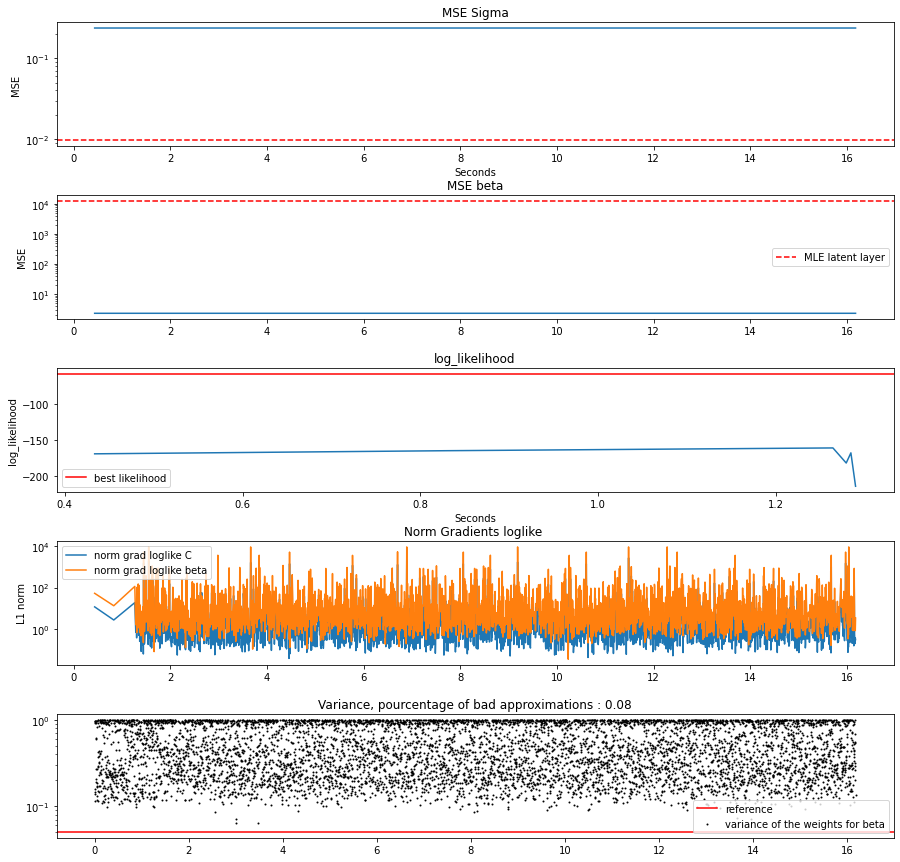

In [158]:
show(model,'', save = False)

In [133]:
d = 2
n = 200;  p = 20
q =8

In [147]:
torch.manual_seed(int(time.time()))
true_Sigma = 1*torch.from_numpy(build_block_Sigma(p,p//2))/2 + 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(true_Sigma, q))
true_beta =torch.randn((d, p))/1

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)

<AxesSubplot:>

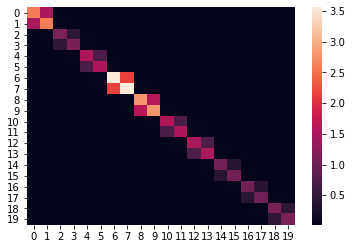

In [148]:
sns.heatmap(true_Sigma.numpy())

In [149]:
print('max :', torch.max(Y_sampled))

max : tensor(191490)


In [22]:
def f(eps) : 
    return torch.mean(torch.abs(torch.log(Y_sampled + eps*(Y_sampled == 0))-Z_sampled))

### $\Sigma$ MLE 

MLE :


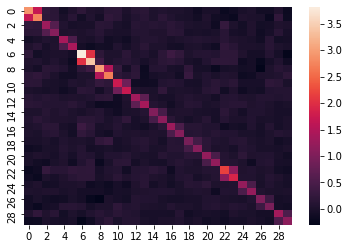

true Sigma


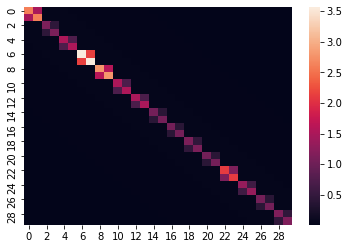

Best MSE we can have (in our dream):  tensor(0.0096)


In [23]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma.to(torch.device('cpu')))
plt.show()
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-true_Sigma)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

### $\beta$ MLE

In [29]:
target = Z_sampled+ torch.mm(covariates,true_beta)

clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
best_MSE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer: ', best_MSE_beta)

MSE beta in the latent layer:  tensor(12542.3301)


$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=\beta^{\top}\mathbf{x}_{i} +\mathbf{C}W_i , \quad i \in 1, \ldots, n \\
Y_{i j} \mid Z_{i j} & \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
\end{aligned}
$$

### First method : direct optimization of the likelihood

We want to maximize the likelihood with respect to $\theta$ : 


$$\max _{\theta} P_{\theta}(Y)$$

But we need to integrate out $W$ in order to compute the quantity inside the max : 

$$
\begin{aligned}
P_{\theta}\left(Y_{i}\right) &=\int P_{\theta}\left(Y_{i}, W\right) d W \\
&=\int P_{\theta}\left(Y_{i} \mid W\right) p(W) d W
\end{aligned}
$$

This integral being untractable, we are going to approximate it with Monte Carlo methods : 

$$
\int p_{\theta}\left(Y_{i} \mid W\right) p(W) d W \approx \frac{1}{K} \sum_{k = 1 }^Kp_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)
$$
$$W_{i,k} \sim \mathcal N (0, I_q)$$

The larger the $K$ the better the approximation.  

Let's compute $p_{\theta}\left(Y_{i} \mid W_i\right) p\left(W_i\right)$. 


First, 

$$
P\left(W_{i}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left\|W_{i}\right\|_{2}^{2}\right)
$$ 

Then, 

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{:,j}+ C_{j}^{\top}W_{i}
$$

Putting all together : 

$$
\begin{aligned}
p_{\theta}\left(Y_{i} \mid W_{i}\right) p\left(W_{i}\right) 
& =\operatorname{const} \times \exp \left(-\frac{1}{2} W_{i}^{\top} W_{i}\right) \exp \left(\sum_{j=1}^{p}-\operatorname{exp}\left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right)\right)\\
&= \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+Z_{i}\right)+Y_{i}^{\top}\left(0_{i}+Z_{i}\right)\right)\\
& = \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top}\left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)\right)\\
& = \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)\\
\end{aligned}
$$

We set $p^{(u)}_{\theta}(W_i) = \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)$

For numerical purposes, we may want to use a logarithmic scale and apply the exponential function after. Indeed, $Y_{ij}$ can go up to a thousand, and computing this factorial would give infinite values. 

$$
\log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\sum_{j=1}^{p} - \ln \left(Y_{i j} !\right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+Z_{i j}\right)
$$

We are going tu use the Stirling Formula in order to compute the log of the factorial, to avoid computing directly the factorial. 


If we consider the whole likelihood : 

$$
\begin{aligned}
\ln p_{\theta}\left(Y \mid W\right) &=\sum_{i=1}^{n} \log p_{\theta}\left(Y_{i} \mid W_{i}\right) \\
&=\sum_{i=1}^{n} \sum_{j} - \ln \left(Y_{ij} ! \right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right) \\
&=1_{n}^{T}\left[-\ln (Y !)-\exp (0+Z)+Y \odot (0+Z)\right] 1_{p} \\
Z=& X \beta+W C^{\top}
\end{aligned}
$$



We now need to compute the gradients. Since 

$$
\nabla_{\theta} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i}| W_{i}\right) \nabla_{\theta} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)
$$

### Gradient computation 


Let's compute $$
\nabla_{{\theta}} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)
$$


We begin with $\beta$. We see the vectors of size $n$ as a matrice of dimension $(n,1)$ ( a line).

We set $A=O+ CW_{i}$

We set 

$$
h: \beta \mapsto \mathbb{1}_{p}^{\top}\exp \left( \beta^{\top}X_{i}+A\right) 
$$

$$
\begin{aligned}
\frac{\partial h(\beta)}{\partial \beta_{k l}} &=\frac{\partial}{\partial \beta_{k l}}\left(\sum_j \exp \left(X_{i}^{\top}\beta_{:, j}+A_{j}\right)\right)\\
&=\frac{\partial}{\partial \beta_{k,l} } \exp \left(X_{i}^{\top} \beta_{:,l}+A_{l}\right) \\
&=\frac{\partial}{\partial \beta_{kl} } \exp \left(\sum_{s} X_{i s} B_{s l}+A_{l}\right)\\
&=\left(\frac{\partial}{\partial \beta_{k l}}\left(\sum_{s} x_{i s} \beta_{s l}+A_{l}\right)\right) \exp \left(\sum_{s} X_{i s} \beta_{sl}+A_l\right) \\
&=X_{i k} \exp \left(\sum_{s} X_{i s} \beta_{s l}+A_{l}\right)\\
&=X_{i k} \exp \left(X_{i}^{\top} \beta_{:,l}+A_{l}\right) \\
&=\left( X_{i}\exp \left( \beta^{\top}X_{i}+A\right) ^{T} \right) _{k 1}
\end{aligned}
$$

So that $$\nabla _{\beta} h =  X_i\exp \left(O_i +  \beta^{\top}X_{i}+  CW_{i,k}\right)^{\top}$$

A similar argument for $$
\tilde h: \beta \mapsto  \sum_{j} Y_{i j}\left(0_{ij}+X_{i}^{\top} \beta_{:,j}+W_{i} C^{\top}_{:,j}\right)
$$

shows that 

$$
\nabla_{\beta} \tilde{h}=X_{i} Y_{i}^{\top}
$$

So that : 
<span style="color:red"> 
$$
\boxed{
\nabla_{\beta} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)= \nabla _{\beta} \tilde h - \nabla _{\beta}  h= X_{i} \left[Y_i - \exp \left(O_i +  \beta^{\top} X_i+CW_{i}  \right) \right]^{\top}}
$$
</span>
A similar argument for $C$ shows that : 
<span style="color:red"> 
$$
\boxed{
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}}
$$
</span>

(Note that if you want to see the vectors as matrices of size (1,n), you only need to  transpose  each vector and it should work fine : 

If we see the vectors as matrices of size (1,n) : 
$$
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i + X_{i} \beta+W_{i}C^{\top}\right)\right]^{\top}  W_{i}
$$

The first vector has a size $(p,1)$, the second $(1,q)$, which makes it $(p,q)$.
)
    

We get : 

$$
\nabla_{\beta} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i} \mid W_{i}\right)
X_{i} \left[Y_i - \exp \left(O_i +  \beta^{\top} X_i+CW_{i}  \right) \right]^{\top}
$$
$$
\nabla_{C} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i} \mid W_{i}\right)
\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}
$$

##### After trying to optimize the likelihood, we have found that the likelihood is very small (the order of the log likelihood is about $-3\times10^{3}$ for some samples which makes the exponential 0 numerically. We need the likelihood to compute the gradients (see above). We can't optimize the log likelihood directly due to the integral : 


$$
\begin{aligned}
\log p_{\theta}(Y) &=\log \left(\int p_{\theta}(Y, W)dW\right) \\
& \approx \log \left(\frac{1}{K}\sum^K p_{\theta}\left(Y, W_{k}\right)\right)\\
& \neq \frac{1}{K} \sum^{K} \log \left(p_{\theta}\left(Y, W_{k}\right)\right)
\end{aligned}
$$

### Importance Sampling 

We thus change the objective function. We want to maximize the log likelihood with respect to $\theta$ : 


$$\max _{\theta}\operatorname{log} P_{\theta}(Y) = \max _{\theta} \sum _i \operatorname{log} p_{\theta}(Y_i)$$
 
 
We need to derive the gradients with respect to theta : 


$$
\begin{aligned}
\nabla_{\theta} \log p_{\theta}(Y_i)&= \frac{\nabla_{\theta} p_{\theta}(Y_i)}{p_{\theta}(Y_i)} \\
&=\frac{\nabla_{\theta} \int p_{\theta}(Y_i \mid W_i) p(W_i) d W}{\int p_{\theta}(Y_i \mid W_i) p(W_i) d W_i}\\
&=\frac{\int \nabla_{\theta} p_{\theta}(Y_i | W_i) p(W_i) d W_i}{\int  p_{\theta}(Y_i|W_i) p(W_i) d W_i}\\
&= \frac{\int\left(\nabla_{\theta} \ln p_{\theta}(Y \mid W)\right) p_{\theta}(Y| W) p(W) d W}{\int p_{\theta}(Y_i \mid W_i)p(W_i) d W_i}\\
&=\int \nabla_{\theta} \ln p_{\theta}(Y_i \mid W_i) \tilde{p}_{\theta}(W_i) dW_i \\
\end{aligned}
$$
$$\tilde p_{\theta}(W_i):=\frac{p_{\theta}(Y_i \mid W_i) p(W_i) d W_i}{\int p_{\theta}(Y_i \mid W_i) p(W_i) dW_i}$$


So that : 

<span style="color:red">
$$
\boxed{\nabla_{\theta} \log p_{\theta}(Y_i) = \mathbb E_{\tilde p } \left[\nabla_{\theta} \ln p_{\theta}(Y_i \mid W_i)\right]}$$ 
</span>

Here $\tilde p $ is the law of $W_i | Y_i$. Indeed : 

$$
\begin{aligned}
p_{\theta}(W_i \mid Y_i) &=\frac{p_{\theta}(Y_i|W_i) \operatorname{p}(W_i)}{p_{\theta}(Y_i)} \\
& = \frac {  {p_{\theta}}\left(Y_i \mid W_{i}\right)p(W_i)}{\int p_{\theta}(Y_i \mid W_i) p(W_i) dW_i}\\
&= \tilde p_{\theta}(W_i)
\end{aligned}
$$
Note also that 

$$\tilde p_{\theta}(W_i) = \frac{p^{(u)}_{\theta}(W_i)}{\int p^{(u)}_{\theta}(W_i) dW_i}$$

We only know the numerator of $ p^{(u)}_{\theta}(W)$. Thus we need to use importance sampling, which consits in the following : 

Let $\phi $ be a mesurable function. Let $g$ be a probability density such that $x \in \operatorname{supp}(\tilde p_{\theta}) \implies g(x)>0$. We denote $(V_{i,k})_k \overset{iid}{\sim} g$. 

We define : 

$$
w_{k}^{(u)}=\frac{p^{(u)}_{\theta}\left(V_{i,k}\right)}{g\left(V_{i,k}\right)}
$$


$$
\tilde{w}_{k}^{(u)}=\frac{w_{k}^{(u)}}{\sum_{\ell=1}^{n} w_{\ell}^{(u)}}
$$


Then, 

$$
\hat{I}_{n_{\text{samples}}}^{I S, u}:=\sum_{k=1}^{n_{\text{samples}}} \tilde{w}_{k}^{(u)} \phi (V_{i,k})
 \stackrel{\text { Proba }}{\longrightarrow} \int \phi(W) \tilde p_{\theta}(W) = \mathbb E _{\tilde p _{\theta}}[\phi(W)]
$$

We need to choose carefully the density $g$ i.e. where $ p^{(u)}_{\theta}\times \nabla_{\theta} \log p_{\theta}$ has a lot of mass.

We start with $\beta$: 


$$
\begin{align*}
\nabla_{\beta} \log {p_{\theta}}(Y_i)&=E_{\tilde{p}_{\theta}}\left[\nabla _ { \beta } \operatorname {log}  p_{\theta} \left(Y_{i}\left|W_{i k}\right)\right]\right.\\
&=X_{i}\left[Y_{i}-\exp \left(0_{i}+ \beta^{\top} X_i\right) \mathbb E_{\tilde p_{\theta}}\left[e^{CW_{i,k} }\right]\right]^{\top}
\end{align*}
$$

Let's look closer at this integral. 

$$\mathbb E_{\tilde p_{\theta}}\left[e^{CW_{i,k}}\right] 
=\left(\begin{array}{l}
E_{\tilde{p}_{\theta}}\left[e^{\left(CW_{i,k}\right)_{1}}\right] \\
\quad \quad  \vdots \\
E_{\tilde p_{\theta}}\left[e^{\left(CW_{i,k}\right)_p}\right]
\end{array}\right)
=\left(E_{\tilde p_{\theta}}\left[e^{u_{m}^{\top}CW_{i} }\right]\right)_{1 \leqslant m\leqslant p}
$$


Where $u_m$ is the canonic vector (i.e. a vector full of zeros except $1$ on the $m$ position)

Let $ 1 \leq m \leq p$.Let $ \phi _{\beta,m}(W)=e^{u_{m}^{\top}CW_{i} } $  Let's look at $E_{\tilde p_{\theta}}\left[\phi _{\beta,m}(W)\right]$

$$
\begin{aligned}
(\star) = E_{\tilde p_{\theta}}\left[\phi _{\beta,m}(W) \right]  &= \int e^{u_{m}^{\top}CW_{i,k} } \frac {p_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)}{{\int p_{\theta}(Y_i,W)  dW}}dW_{i,k} = \int e^{u_{m}^{\top}CW_{i,k} } \frac {p^{(u)}_{\theta}(W_i)}{\int p^{(u)}_{\theta}(W_i) dW_i} \\
& =  \frac {1}{\int p^{(u)}_{\theta}(W) dW}\int  \exp \left(u_{m}^{\top}CW_{i,k}-\frac{1}{2}\left\|W_{ik}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i,k}\right)+Y_i^{\top}CW_{i,k}\right)d W_{i,k} \\
& =  \frac {1}{{\int p^{(u)}_{\theta}(W)  dW}}\int  \exp \left((u_{m}+Y_i)^{\top}CW_{i,k}-\frac{1}{2}\left\|W_{ik}\right\|^{2} -\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i,k}\right)\right)d W_{i,k}\\
\end{aligned}
$$


We set 
$$
\mu_{m}:=\left(u_{m}+Y_{i}\right)^{\top} C
$$

Let $(V_{i,k,m})_k  \overset{iid}\sim \mathcal N(\mu_{m}, I_q)$ ang $g_m$ the corresponding density. 

Then, $$ \begin {aligned}
g_m(V) & = \frac{1}{(2 \pi)^{q / 2}} \exp \left[-\frac{1}{2}(\boldsymbol{V}-\boldsymbol{\mu_m})^{\top} (\boldsymbol{V}-\boldsymbol{\mu_m})\right]\\
& = \frac{1}{(2 \pi)^{q / 2}} e^{-\frac{\mu_m ^{\top} \mu_m}{2}} e^{- \frac 1  2 V^{\top} V+V^{\top} \mu_m}
\end{aligned}
$$

We set $A(\mu_m) = \frac{1}{(2 \pi)^{q / 2}} e^{-\frac{\mu_m ^{\top} \mu_m}{2}}$






Let's compute the importance weights for $g$. 

$$
\begin{aligned}
w^{(u)}_k & = \frac{p^{(u)}_{\theta}\left(V_{i,k}\right)}{g\left(V_{i,k}\right)} \\
& = \frac { \exp \left(-\frac{1}{2}\left\|V_{i,k}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right)+Y_{i}^{\top} CV_{i,k}\right)}{A(\mu _m ) e^{- \frac 1  2 V_{i,k}^{\top} V_{i,k}+V_{i,k}^{\top} \mu_m}} \\
& = \frac 1 {A(\mu _m)  } \operatorname{exp}\left(-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right) - u_m^{\top}CV_{i,k}\right)
\end{aligned}
$$

Note that in practice, setting $\mu _m = 0$ works better. We will see why after. 


Computation for the gradient of $C$ : 

$$
\begin{align*}
\nabla_{C} \log {p_{\theta}}(Y_i)&=E_{\tilde{p}_{\theta}}\left[\nabla _ { C } \operatorname {log}  p_{\theta} \left(Y_{i}\left|W_{i k}\right)\right]\right.\\
&= \mathbb E_{\tilde p_{\theta}}\left[\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}\right]\\
&= Y_{i}\mathbb E_{\tilde p_{\theta}} \left[ W_i^{\top} \right] -\exp(O_i + \beta^{\top}X_i) \mathbb E_{\tilde p_{\theta}}\left[\exp \left(CW_{i}{ }\right)  W_{i}^{\top}\right]
\end{align*}
$$

Let's look closer at the integrals. 
$$
E_{\tilde p_{\theta}}\left[\exp \left(CW_{i}{ }\right)  W_{i}^{\top}\right] = (E_{\tilde p_{\theta}}\left[\exp \left(u_k^{\top} CW_{i}\right)  W_{i}^{\top}u_m\right])_{1 \leq k \leq p, 1 \leq m \leq q}
$$

$$\mathbb E_{\tilde p_{\theta}} \left[ W_i^{\top} \right] = \mathbb E_{\tilde p_{\theta}} \left[ W_i^{\top}u_m \right]_{1 \leq m \leq q}
$$

We only need to approximate these integrals and we can compute the gradients.



### Choosing the law g

We want to get a good law $g$ for importance sampling. 
We will try to modify the model so that the law inside the integral are computable and we hope it will help. 

We look at the following model : 

$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=O_i +  \beta^{\top}\mathbf{x}_{i} +\mathbf{C}W_i , \quad i \in 1, \ldots, n \\
\operatorname{log} (Y_{i}) \mid Z_{i} & \sim \mathcal{N}\left( Z_{i}, \operatorname{diag}(\exp(-|O_i +\beta ^{\top} X_i |)\right)
\end{aligned}
$$

We denote $D_i:= \operatorname{diag}(\exp(-|O_i +\beta ^{\top} X_i |)$.

Here are the heuristics for choosing this model. 
First, we approximate the Poisson law with a gaussian: 

$$\mathcal P (exp(Z_i)) \approx \mathcal N(\exp(Z_i), \operatorname{diag} (\exp(Z_i))$$ 



Now, with some computation ( see for example the end of the notebook) 

we can do this approximation : 

$$ \exp (\mathcal N (Z_i, \operatorname{diag}(\exp(-|Z_i|)) \approx \mathcal N (\exp(Z_i), \operatorname{diag}(\exp(Z_i))$$

For computation purposes and to have a law that is computable, we need to remove $CW$ from the variance term inside the absolute value(to get back a gaussian when computing the law of the latent variables given the observation), which gives the heuristic. 

After some computation, we find that given this model, we can compute the law $W_i|Y_i$ : 

$$W_i|Y_i \sim \mathcal N((\log(Y_i)-X_i\beta)^{\top}D^{-1}C, (C^{\top}D^{-1}C + I)^{-1})$$ 

The better $g$ we can take ( to approximate $\mathbb E _{p_{\theta}(W_i|Y_i)}\left[e^{ u_m^{\top}CW_i}\right]$ being the law  : $$g^{\star}(x) = e^{ u_m^{\top}Cx} p_{W_i|Y_i}(x) , x \in R^q$$

After some little computation we find that : 

$$ g^{\star}(x) = \mathcal N (x; (\log(Y_i)-X_i\beta)^{\top}D^{-1}C + u_m^{\top}C, (C^{\top}D^{-1}C + I)^{-1})$$

### Computation of the law of $W_i|Y_i$ for the modified model. 

We set $$\mu_i := \log(Y_i) -X_i\beta$$

Let's compute the law of the latent variables given the data.

\begin{aligned}
p_{\theta}\left(W_{i} \mid \log \left(Y_{i}\right) \right) & = p_{\theta}\left(\log \left(Y_{i}\right) \mid W_{i}\right) p\left(W_{i}\right) \\
& = C \times \exp \left(-\frac{1}{2}\left(\left(CW_{i}-\mu_{i}\right)^{T} D^{-1}\left(CW_{i}-\mu_{i}\right)+W_{i}^{\top} W_{i}\right)\right) \\
& C \times \exp \left(-\frac{1}{2}\left(W_{i}^{\top}C^{\top}D^{-1}CW_{i}-2\mu_{i}^{\top}D^{-1}CW_i+\mu_i^{\top}D^{-1}\mu_i+W_{i}^{\top} W_{i}\right)\right) \\
& = C \times \exp \left(-\frac{1}{2}\left(W_{i}^{\top}\left(C^{\top}D^{-1}C+ I_q\right)W_{i}\right)+\mu_{i}^{\top}D^{-1}CW_i\right)
\end{aligned}

By identification : 

$$W_i |\log(Y_i) \sim \mathcal N \left(C^{\top}D^{-1}\mu_i, (C^{\top}D^{-1}C+ I_q)^{-1} \right) $$

Then, 

$$ u_m^{\top}C W_i |\log(Y_i) \sim \mathcal N\left(u_m^{\top}CC^{\top}D^{-1}\mu_i, u_m^{\top}C(C^{\top}D^{-1}C+ I_q)^{-1}C^{\top}u_m \right)$$

sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$C :  (p,q)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

In [ ]:
show(model,'', save = False)

### some functions I tried, might be useful but not clean. 

In [30]:
def plot_estimation_pq(vect, true_int_pq):
    p,q = vect.shape[1],vect.shape[2]
    fig, axs = plt.subplots(p,q, figsize = (15,10))
    var_estim = np.empty((p,q))
    for i in range(p): 
        for j in range(q):
            var_estim[i,j] = np.var(vect[:,i,j])
            axs[i,j].hist(x = vect[:,i,j], density = True,bins = 100, label = 'var = ' + str(np.round(var_estim[i,j],8)))
            axs[i,j].axvline(true_int_pq[i,j], c = 'red', label = 'true value : ' + str(np.round(true_int_pq[i,j], 4)))
            mean = np.mean(vect[:,i,j])
            axs[i,j].axvline(mean, c = 'black', label = 'value found : ' + str(np.round(mean, 4)))
            axs[i,j].legend()
    #plt.savefig('good approximation')
    plt.show()
    return var_estim
def plot_estimation_p(vect):
    p = vect.shape[1]
    fig, axs = plt.subplots(p, figsize = (15,10))
    var_estim = np.empty(p)
    for i in range(p):
        var_estim[i] = np.var(vect[:,i])
        axs[i].hist( x = vect[:,i], bins = 100, label = 'var =' + str(np.round(var_estim[i],10)))
        #sns.histplot(ax = axs[i], x = vect[:,i],label = 'var = ' +str(var_estim[i],3))
        axs[i].legend()
    
    plt.show()
    return var_estim 
vect = torch.randn(100000,p,q).numpy()


def get_var(vect):
    return torch.var(vect, dim = 0)

def MSE(a,b): 
    return torch.mean((a-b)**2)


vect = torch.randn(1000,p,q).numpy()

#get_var(vect)
#plot_estimation_pq(vect, torch.zeros(p,q))
#plot_estimation_p(torch.randn(100000,p).numpy()*8)

In [13]:
from fastPLN import fastPLN


fastmodel = fastPLN()
fastmodel.fit(Y_sampled,O,covariates, 100)

NameError: name 'Y_sampled' is not defined

In [46]:
math.log(0.01)

-4.605170185988091

In [284]:
print('max : ', torch.max(Y_sampled))
print('max Z :', torch.max(Z_sampled- covariates@true_beta))
print('min Z ', torch.min(Z_sampled-covariates@true_beta))

max :  tensor(222409)
max Z : tensor(10.4042)
min Z  tensor(-11.0066)


In [282]:
print('Z : ', Z_sampled)

Z :  tensor([[ 1.2649, -1.9753, -1.7857,  ..., -0.1341, -0.1546, -0.4025],
        [ 0.4435,  0.3753, -0.7671,  ...,  0.3002, -0.2035,  0.4904],
        [ 0.4048, -0.2772, -0.2117,  ..., -1.1684,  0.2867,  1.0381],
        ...,
        [ 0.5275, -0.7550,  0.6449,  ...,  0.6831, -1.6798, -0.9961],
        [-0.5718, -0.7060,  0.4333,  ..., -0.5924,  0.9189,  1.0892],
        [ 0.0660,  0.7319, -1.3140,  ..., -0.4854, -1.3933,  1.2796]])


cov :  tensor(11.0066)


In [ ]:
model.compute_mean_log_likelihood(0.0001)[0].item()

tensor([[4.0000e+00, 7.0000e+00, 4.5150e+03,  ..., 2.8000e+01, 1.0000e-02,
         1.0000e+00],
        [6.0000e+00, 1.0000e+00, 3.0000e+00,  ..., 1.0000e-02, 1.0000e-02,
         1.0000e-02],
        [2.0000e+01, 1.0000e-02, 1.4900e+02,  ..., 2.0000e+00, 3.0000e+00,
         4.0000e+00],
        ...,
        [2.9000e+01, 6.0000e+00, 1.0000e-02,  ..., 4.7100e+02, 2.0000e+00,
         4.1000e+01],
        [3.2000e+01, 1.0000e-02, 1.0000e-02,  ..., 4.0000e+00, 1.0000e-02,
         3.0000e+00],
        [8.0000e+00, 1.0000e+00, 1.0000e-02,  ..., 3.0000e+01, 1.0000e-02,
         1.0000e-02]])

## some functions i tried, useless

In [14]:
def IMPS(f, p, q, acc):
    N_samples = int(1/acc)
    sqrtm_prop = torch.from_numpy(SLA.sqrtm(Sigma_prop))
    weights = torch.zeros(N_samples)
    W = torch.randn(N_samples,N)+mu_prop
    for i in range(N_samples):
        weights[i] = p(W[i])/q(W[i])
    weights/= torch.sum(weights)
    var = get_var(weights)
    return torch.sum(torch.squeeze(f(W))*weights), var 
    
def f(Z):
    if len(Z.shape)> 1 : 
        t = torch.ones(Z.shape[1],1)
    else : 
        t = torch.ones(Z.shape)
    return torch.exp(Z@t)

def Ndensity(Z,mu,inv_Sigma): 
    return torch.exp(-1/2*(Z-mu).reshape(1,-1)@inv_Sigma@((Z-mu).reshape(-1,1)))/(torch.sqrt(1/torch.det(inv_Sigma)*(2*math.pi)**N))      
def p(Z): 
    return Ndensity(Z,mu,inv_Sigma)
def q(Z): 
    return Ndensity(Z,mu_prop, inv_Sigma_prop) 
    

Z_exp_moment,argmax_2D = plot_2D(f_expmoment,abscisse,abscisse)

NameError: name 'plot_2D' is not defined

In [ ]:
def plot_2D(f,x_abscisse, y_abscisse):
    Z = np.zeros((len(x_abscisse), len(y_abscisse)))
    maxi = 0
    argmax = (0,0)
    for i,x in enumerate(x_abscisse): 
        for j,y in enumerate(y_abscisse):
            xy_ten = torch.tensor([x,y])
            value = (f(xy_ten))
            if value > maxi : 
                argmax = (i,j)
                maxi = value
            
            Z[i,j]= value
            
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x_abscisse,y_abscisse)
    ax.plot_surface(X, Y, Z.T, cmap = cm.coolwarm)
    plt.show()
    return Z, (abscisse[argmax[0]],abscisse[argmax[1]]) 
    

    
def f_expmoment(Z): 
    return torch.exp(torch.sum(Z))*p(Z)





In [ ]:
def plot_1D(f, abscisse): 
    values = list()

    for w in abscisse : 
        valeur = torch.tensor([w])
        values.append(np.squeeze((valeur*f(valeur)).numpy()))

    argmax = abscisse[np.argmax(values)]
    plt.plot(abscisse,np.abs(values))
    plt.axvline(argmax)
    plt.show()
    return argmax

In [15]:
Z = np.zeros((len(abscisse), len(abscisse)))
for i,x in enumerate(abscisse): 
    for j,y in enumerate(abscisse) :
        xy_ten = torch.tensor([x,y])
        Z[i,j]= (p(xy_ten))*torch.tensor([y])
        

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(abscisse,abscisse)
ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
plt.show()

NameError: name 'abscisse' is not defined

In [ ]:
abscisse = torch.linspace(-10,10,200)
Z = np.zeros((len(abscisse), len(abscisse)))
for i,x in enumerate(abscisse): 
    for j,y in enumerate(abscisse) :
        xy_ten = torch.tensor([x,y])
        Z[i,j]= (p(xy_ten))
        

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(abscisse,abscisse)
ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
plt.show()

In [ ]:
plot_2D(p,abscisse,torch.linspace(-5,5,100))

In [16]:
fastmodel = fastPLN()
%time fastmodel.fit(Y_sampled,O,covariates, 20)
fastSigma = fastmodel.Sigma
fastBeta = fastmodel.beta
print('beta', MSE(true_beta,fastmodel.beta))

print('Sigma', MSE(true_Sigma,fastmodel.Sigma))

variational_model = MC_PLNPCA(q, batch_size, true_value = True)
variational_model.init_data(Y_sampled, O, covariates)
variational_model.Sigma = fastSigma
variational_model.beta = fastBeta

NameError: name 'Y_sampled' is not defined

AttributeError: 'fastPLN' object has no attribute 'Sigma'

In [ ]:

    def get_conditional_density_j(self, j,Y_i,covariates_i, O_i,best_mean,  N_points): 
        '''
        get the conditional density on the dimension j (i.e. the density of W_j|(Y_i,W_-j) ). We will return 
        a list of some points of the density to plot it. 
        
        
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            best_mean : tensosr of size q. The mean of the best gaussian approximation you found. 
            N_points : int. The number of points you want in your plot. 100 is a good choice in general. 
        returns : 
            abscisse : a list that discretize the space of interest. i.e. a discretazion of 
            [best_mean[j]-3, best_mean[j]+3]
            density : the value of P_WYgivenY along the abscisse, for W_-j fixed and W_j is moving along the  abscisse. 
        '''
        #We get a mask so that we can fixed the values of best_mean except the j-th coordinate. We will move 
        # the j-th coordinate along the abscisse. 
        mask = torch.zeros(best_mean.shape[0], dtype = torch.bool)
        mask[j]= True
        #get the abscisse. for the abscisse, the space of interest is around best_mean[j] since 
        #W_j|Y_i,W_-j is roughly a gaussian centered in best_mean[j]
        abscisse = np.linspace(best_mean[j].detach().numpy()-3,best_mean[j].detach().numpy()+3,N_points)
        list_density = np.array([self.log_P_WYgivenY(Y_i,covariates_i,O_i,
                        best_mean.masked_scatter(mask,torch.Tensor([w]))).detach().numpy()
                                for w in abscisse])
        list_density-= np.max(list_density)# we remove the max to avoid nan Values when we take the exponential 

        density = np.exp(list_density)# we had the log so we need to take the exp now 
        
        return abscisse,density
    
    
    def plot_conditional(self,Y_b, covariates_b, O_b,gaussian_mean_b, N_points = 100):
        '''
        plot the density of the conditional densities W_j|Y_i,W_-j for i in range(self.batch_size) 
        and j in range(q)
        Thus, the figure  will contain n_batch*q plot. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            gaussian_mean_b : tensor of size (n_batch,q) that contains the mean of the best gaussian
            approximation 
            N_points : the number of points you want in your plot. The larger the smoother the curve. 
            
        returns : None, but display the figure
        '''
        
        fig = plt.figure(figsize = (20,10))
        axes = fig.subplots(gaussian_mean_b.shape[0], gaussian_mean_b.shape[1])
        for i, (Y_i,covariates_i, O_i, gaussian_mean_i) in enumerate(zip(Y_b, covariates_b, O_b,gaussian_mean_b)): 
            for j in range(gaussian_mean_b.shape[1]): 
                abscisse, density = self.get_conditional_density_j(j,Y_i,covariates_i, O_i, gaussian_mean_i, N_points)
                true_max = abscisse[np.argmax(density)]# get the true max to plot it. 
                
                #normal_density = np.exp(np.array([-1/(2*self.sigma**2)*(w-gaussian_mean_b[i,j])**2 for w in abscisse])) 
                try : 
                    #density of a gaussian centered in gaussian_mean_b[i,j] to see the approximation
                    normal_density = np.exp(np.array([-1/(2*self.sigma**2)*(w-gaussian_mean_b[i,j].item())**2 for w in abscisse])) 
                    normal_density*= np.max(density)/np.max(normal_density)# We renormalize by some constants to plot similar things. 
                    axes[i,j].plot(abscisse, density, label = 'W|Y density')
                    axes[i,j].plot(abscisse, normal_density, label = 'Gaussian density')
                    axes[i,j].axvline(gaussian_mean_b[i,j], c = 'green', label = 'maximum found') # the max we found
                    axes[i,j].axvline(true_max, c = 'black', label = 'true_max')# the true max. 
                except : 
                    pass
                
        # We display the labels above and once. 
        lines, labels = fig.axes[0].get_legend_handles_labels()
        fig.legend(lines, labels, loc = 'upper center')
        plt.show()


    def batch_grad_log_beta(self, Y_b,covariates_b, O_b, W):
        '''
        computes the gradient of the log of the density for a batch, with respect to beta. 
        
        args:
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : 
            the gradient of the log of the density. The formula is above. 
        '''
        #we do not sum up since we will need to multiply each quantity with a Monte Carlo approximation
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return  (covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b)) # unsqueeze is here so that the transpose
                                                                    #makes sense
    
    def grad_log_beta(self, Y_i, covariates_i, O_i, V_k): 
        '''
        same as batch_grad_log_beta but for only one sample Y_i, covariates_i and O_i. 
        '''
        Z_i = O_i + covariates_i@self.beta + V_k@(self.C.T)
        return covariates_i.unsqueeze(1)@((-torch.exp(Z_i)+Y_i).unsqueeze(0))
    
    def batch_grad_log_C(self, Y_b,covariates_b, O_b, W):
        '''
        same as batch_grad_log_beta but the gradients is taken with respect to C.
        '''
        #we do not sum up since we will need to multiply each quantity with a Monte Carlo approximation
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return ((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W)
    
    def grad_log_C(self, Y_i, covariates_i, O_i, V_k): 
        '''
        same as grad_log_beta but the gradient is taken with respect  to C. 
        '''
        Z_i = O_i + covariates_i@self.beta + V_k@(self.C.T)
        return ((-torch.exp(Z_i)+Y_i).unsqueeze(1))@V_k.unsqueeze(0)
        
    def get_batch_weights(self, Y_b, covariates_b, O_b,V_b, gaussian_mean_b):
        '''
        function to get the weights (weights formula in the importance sampling)
        for one batch . We take the log and then the exponential to avoid Nan values. 
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            V_b : torch of size (n_samples, n_batch,q). should be a gaussian. 
            gaussian_mean_b : tensor of size(n_batch,q). 
            
        return : the weights (formula above), of size (n_batch)
        '''
        # see formula above. 
        log_f = self.batch_log_P_WYgivenY(Y_b,covariates_b,O_b,V_b)
        log_g = self.batch_log_g(V_b,gaussian_mean_b)
        log_fminus_log_g = log_f -log_g 
        return torch.exp(log_fminus_log_g - torch.max(log_fminus_log_g, axis = 0 )[0]) #C*f/g

def find_each_mean(self,Y_b,covariates_b, O_b, lr = 0.5, N_iter_max = 100,class_optimizer = torch.optim.Rprop):
        '''
        method to compute the mean of the best gaussian approximation of W|Y_b. We will compute n_batch * q 
        approximation. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            lr : float. positive. the learning rate of the optimizer
            N_iter_max : the number of iteration you want to do. 
            class_optimizer : torch.optim.optimizer object.  the class of the optimizer. should be like 
                              torch.optim.Rprop. 
        returns : 
                W : the parameter that maximizes the log of the probability of P_WY given Y.
        '''
        W = torch.randn(self.batch_size,self.q) # here only to evaluate a function, we won't use it to 
                                                # approximate some function. 
        W.requires_grad_(True)
        optimizer = class_optimizer([W], lr = lr)
        i = 0
        while i < N_iter_max:  #and delta > tol :
            loss = -self.each_log_P_WYgivenY(Y_b,covariates_b, O_b, W) #compute the loss 
            loss.mean().backward()#We take the mean since we have a loss of (n_batch,q) dimensions. 
            optimizer.step()
            i+=1
            optimizer.zero_grad()
            if torch.isnan(loss).any() : 
                print('NANloss, find_each_mean funct : ', loss)
            
        return W 
    
    def fit_IMPS(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            #self.compute_mean_log_likelihood(acc)
            for i, (Y_b, covariates_b, O_b) in enumerate(self.get_batch(self.batch_size)):
                
                if i //10 == 0 : 
                    print('MSE Sigma ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    print('-------------MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                 # we find the best gaussian_mean for the approximation
                gaussian_mean_b =  self.find_each_mean(Y_b, covariates_b, O_b,N_iter_max = 100)
                if i == -1 : 
                    self.gaussian_list.append(gaussian_mean_b)
                    #self.plot_conditional(Y_b, covariates_b, O_b,gaussian_mean_b)
                #print('gaussian ' , gaussian_mean_b)
                self.compute_batch_mean_log_likelihood(Y_b, covariates_b, O_b,gaussian_mean_b,i,acc)
                # sample some gaussians with the mean of the best gaussian approximation we found
                V_b = torch.randn(N_samples,self.batch_size, self.q)*self.sigma+gaussian_mean_b
                
                weights =  self.get_batch_weights(Y_b, covariates_b, O_b,V_b, gaussian_mean_b) # weights
                
                normalized_weights = weights/torch.sum(weights, axis = 0)#normalization (see formula above)
                
                # gradients of the log likelihood 
                grad_C = self.batch_grad_log_C( Y_b,covariates_b, O_b, V_b)
                grad_beta = self.batch_grad_log_beta( Y_b,covariates_b, O_b, V_b)
                # We mulitplu this with the weights (see formula)
                grad_C = torch.multiply(grad_C.unsqueeze(1),normalized_weights.unsqueeze(2).unsqueeze(3))
                grad_beta = torch.multiply(grad_beta.unsqueeze(1),normalized_weights.unsqueeze(2).unsqueeze(3))
                # We sum over the batches and the samples (maybe take the mean along the batch axis or not)
                grad_C = torch.mean(torch.sum(grad_C, axis = (0)), axis = 0)
                grad_beta = torch.mean(torch.sum(grad_beta, axis = (0)), axis = 0)

                self.C.grad = -grad_C 
                self.beta.grad = -grad_beta
                # keep records 
                self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
                self.norm_grad_log_beta_list.append(torch.norm(grad_beta).item())
                self.norm_grad_log_C_list.append(torch.norm(grad_C).item())
                self.running_times.append(time.time()-self.t0)
                optim.step()
                optim.zero_grad()
            print('-----------------------------------------------------------------------------')
            print('-----------------------------------------------------------------------------')
            print('-----------------------------------------------------------------------------')
            print('----------------------------------------------------------------------------------------------------------------------------------------NEWBATCH')

    def batch_log_g(self,V_b, gaussian_mean_b): 
        '''
        method that computes the log of the density of a gaussian of mean gaussian_mean_b and variance 
        self.sigma*I. 
        
        args : 
            V_b : tensor of size (n_samples, n_batch, self.q). 
            
        returns : 
            the log density for each self.q dimensional gaussian (i.e. a tensor of size (n_samples, n_batch))
        '''
        
        const = -self.q/2*math.log(2*math.pi)-self.q*math.log(self.sigma) # the constant on the gaussian   
        return const -1/(2*self.sigma**2)*torch.norm(V_b-gaussian_mean_b, dim = 2)**2

In [17]:
'''
    def likelihood_grad_batch_beta(self, Y_b,covariates_b, O_b, W):
        likelihood = self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        nb_non_zero = torch.sum(likelihood >0)
        grad_log = (covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b))
        if nb_non_zero > 0 : 
            self.norm_grad_log_beta_list.append(torch.mean(torch.abs(torch.sum(grad_log, axis = 0)/nb_non_zero)).item())
        
        return torch.sum(likelihood.reshape(-1,1,1)*grad_log, axis = 0)/nb_non_zero



    def likelihood_grad_batch_C(self, Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        grad_log = ((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W)
        nb_non_zero = torch.sum(likelihood >0)
        #print('non_zero : ', nb_non_zero)
        if nb_non_zero > 0 : 
            self.norm_grad_log_C_list.append(torch.mean(torch.abs(torch.sum(grad_log, axis = 0)/nb_non_zero)).item())
            
        return torch.sum(likelihood.reshape(-1,1,1)*grad_log, axis = 0)/nb_non_zero 
'''


def fit_IMPS_nobatch(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            #self.compute_mean_log_likelihood(acc)
            for (Y_b, covariates_b, O_b) in self.get_batch(self.batch_size):
                for i in range(self.batch_size): 
                    Y_i, covariates_i, O_i = Y_b[i], covariates_b[i], O_b[i]

                    def p_u(x,y): 
                        W_i = torch.tensor([x,y])
                        return self.p_u_theta(Y_i, covariates_i, O_i,W_i)
                    normalizer = 0 
                    #normalizer, residual =  integrate.dblquad(p_u, -10,10,-10,10)
                    #print('normalizer, residual : ', normalizer, residual)
                    
                    #V_i = torch.empty(self.p, N_samples, self.q)
                    #esp_beta = torch.empty(self.p)
                    #for m in range(p):
                    #    esp_beta[m] = model.beta_MC_term_m(Y_i,covariates_i,O_i, m, N_iter,normalizer)
                        
                    #print('esp_beta', esp_beta)
                    esp_C_exp = torch.empty(self.C.shape)
                    esp_C_W = torch.empty(self.q)
                    
                    for l in range(q):
                        esp_C_W[l] = self.C_MC_term_m(Y_i, covariates_i, O_i, l, N_samples,normalizer)
                        for k in range(p):
                            esp_C_exp[k,l] = self.C_MC_term_kl(Y_i, covariates_i, O_i, k,l, N_samples,normalizer)
                    
                    #print('old exp : ', esp_C_exp)
                    esp_beta,esp_C_W, eso_C_exp = self.MC_term(Y_i, covariates_i, O_i, N_samples)
                    
                    
                    self.beta.grad = - torch.outer(covariates_i, Y_i - torch.exp(O_i + covariates_i@self.beta)*esp_beta)
                    self.C.grad = -torch.outer(Y_i, esp_C_W) + torch.exp(O_i + covariates_i@self.beta).reshape(-1,1)*esp_C_exp
                    optim.step()
                    optim.zero_grad()
                    print('mse_beta', torch.mean((self.beta- true_beta)**2))
                    print('mse Sigma', torch.mean((self.get_Sigma() -true_Sigma)**2))
                    

In [20]:
show(model,'bad var  ', save = False )

NameError: name 'model' is not defined

This is if we take only one sample $Y_i$. If we take the whole dataset (or a mini-batch), we get (writed in matrix form) :

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

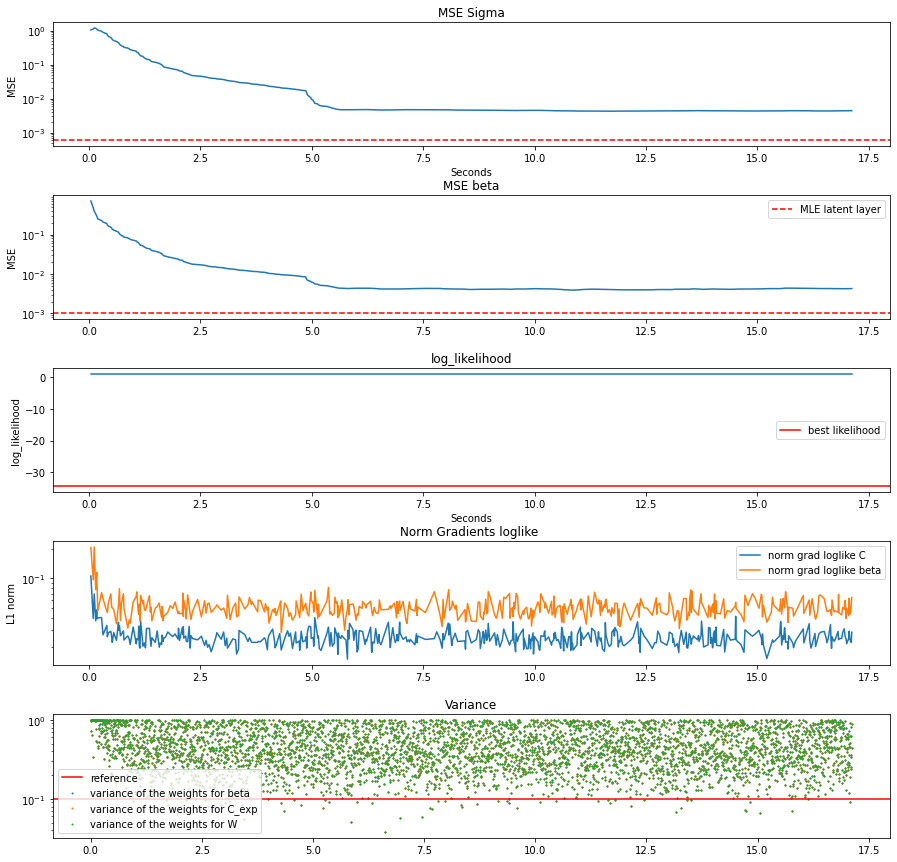

In [21]:
show(model,'',save = False)

We look for a law that is closer to : 

$$
p_{target}(W) := \frac{p_{target}^{(u)}(W)}{\int p_{target}^{(u)}(W)}
$$

$$
p_{target}^{(u)}(W) : = p_{\theta}\left(Y_{i} \mid W\right) p(W_{i,k}) |\nabla_{\theta} \ln p_{\theta}\left(Y_{i} \mid W\right)|
$$

Mathématiquement, on fait ça : 
Si $W$ est de taille $q$, on calcule 

In [37]:
true_Sigma

tensor([[2.6059, 1.4867, 0.0451, 0.0429, 0.0407, 0.0387, 0.0368, 0.0349, 0.0332,
         0.0315, 0.0299, 0.0284, 0.0270, 0.0257, 0.0244, 0.0232, 0.0220, 0.0209,
         0.0199, 0.0189],
        [1.4867, 2.6059, 0.0475, 0.0451, 0.0429, 0.0407, 0.0387, 0.0368, 0.0349,
         0.0332, 0.0315, 0.0299, 0.0284, 0.0270, 0.0257, 0.0244, 0.0232, 0.0220,
         0.0209, 0.0199],
        [0.0451, 0.0475, 1.1301, 0.4535, 0.0451, 0.0429, 0.0407, 0.0387, 0.0368,
         0.0349, 0.0332, 0.0315, 0.0299, 0.0284, 0.0270, 0.0257, 0.0244, 0.0232,
         0.0220, 0.0209],
        [0.0429, 0.0451, 0.4535, 1.1301, 0.0475, 0.0451, 0.0429, 0.0407, 0.0387,
         0.0368, 0.0349, 0.0332, 0.0315, 0.0299, 0.0284, 0.0270, 0.0257, 0.0244,
         0.0232, 0.0220],
        [0.0407, 0.0429, 0.0451, 0.0475, 1.5290, 0.7328, 0.0451, 0.0429, 0.0407,
         0.0387, 0.0368, 0.0349, 0.0332, 0.0315, 0.0299, 0.0284, 0.0270, 0.0257,
         0.0244, 0.0232],
        [0.0387, 0.0407, 0.0429, 0.0451, 0.7328, 1.5290, 0.0

In [106]:
model.Sigma_mean

tensor([[ 1.0980,  0.2210,  0.3630,  0.1901,  0.7131,  0.1715, -0.0519,  0.0104,
          0.7279,  0.0804, -0.3726,  0.1799, -0.1716, -0.2042,  0.4783, -0.3307,
          0.1959, -0.1618,  0.5008,  0.6957],
        [ 0.2210,  0.7539,  0.1707,  0.3933,  0.6718,  0.4209,  0.1215,  0.3440,
         -0.0427,  0.0800,  0.1070,  0.3023,  0.2277, -0.0959,  0.0944, -0.4976,
          0.0096,  0.1552,  0.2060,  0.2206],
        [ 0.3630,  0.1707,  1.9334,  0.5031,  0.8632,  0.5982, -0.7425,  0.1734,
         -0.1651,  1.4959,  0.0821,  0.4415, -0.9607,  0.0814,  0.5434, -1.1458,
          0.1872, -0.0935, -0.7550,  0.3093],
        [ 0.1901,  0.3933,  0.5031,  0.6298,  0.8744,  0.4038, -0.1516,  0.5176,
          0.0197,  0.4418,  0.2201,  0.3958,  0.0503, -0.2344,  0.3390, -1.2385,
          0.3101,  0.1885, -0.4515,  0.0993],
        [ 0.7131,  0.6718,  0.8632,  0.8744,  2.3950,  0.3175,  0.3082,  1.1422,
          0.1182,  0.9556,  0.0386,  1.2390, -0.0927, -0.4725,  0.8591, -2.2763,
      

In [103]:
torch.mean((model.Sigma_mean-true_Sigma)**2)

tensor(0.3137)

In [23]:

print(a[0,0,0,:]@b[0,0,:,0])
res[0,0]

NameError: name 'a' is not defined

In [23]:
y = -7
c = 1.

In [24]:
def f_(w): 
    expc = np.exp(c*w)
    return np.exp(-1/2*((y-expc)**2 + w**2))

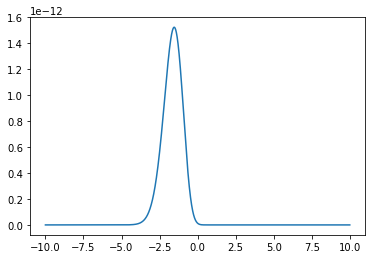

In [26]:
abscisse = np.arange(-10,10,0.01)
plt.plot(abscisse, f_(abscisse))

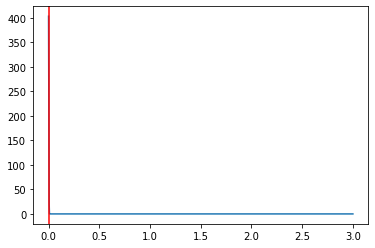

In [194]:


def d_expexp(w): 
    return 1/(np.exp(z/2))*np.exp(-1/(2*np.exp(z))*(w-np.exp(z))**2)

abscisse = np.linspace(0.7*np.exp(z), 1.1*np.exp(z)+3, 1000)

plt.plot(abscisse, d_expexp(abscisse))
plt.axvline(math.exp(z), c = 'red')

In [19]:
show(model,'bad var  ', save = False )

NameError: name 'model' is not defined

In [25]:
true_Sigma

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5000]])

In [26]:
Y_sampled

tensor([[0, 1, 0,  ..., 3, 0, 2],
        [0, 1, 2,  ..., 1, 0, 5],
        [0, 0, 0,  ..., 4, 0, 1],
        ...,
        [2, 2, 1,  ..., 2, 1, 0],
        [0, 1, 0,  ..., 0, 4, 2],
        [0, 0, 3,  ..., 0, 3, 0]])

### heuristics for approximation of the gaussian of an exponential by the exponential of a gaussian

In [232]:
def sample_expexp(gaussian,z): 
    return np.exp(z) + gaussian*np.sqrt(np.exp(z))
def sample_exp(gaussian,z): 
    return z + gaussian*np.sqrt(np.exp(-np.abs(z)))

In [233]:
z = -5
gaussian = np.random.randn(1000)
V = sample_expexp(gaussian,z)
#log_V = np.log(V)

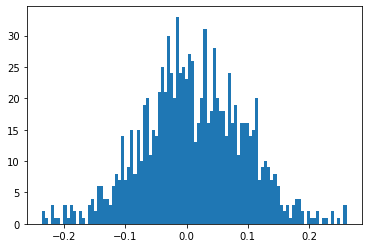

In [234]:
hist = plt.hist(V, bins = 100)
plt.show()
#hist_log = plt.hist(log_V, bins = 100)

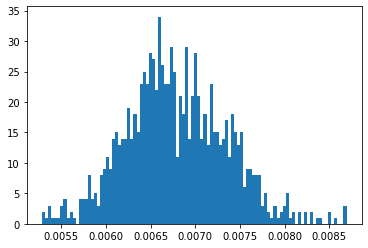

In [235]:
trylog_V = sample_exp(gaussian,z)
try_V = np.exp(trylog_V)
hist = plt.hist(try_V, bins = 100)

In [213]:
try_var = np.var(try_V)
try_mean = np.mean(try_V)

print('true_mean : ', np.mean(V))
print('try mean ', try_mean)
print('true_var ', np.var(V))
print('try var ', try_var)


true_mean :  0.007646401369724009
try mean  0.00676683512904653
true_var  0.0067271582935046845
try var  3.1071408664673343e-07


In [214]:
np.sqrt(try_var)

0.0005574173361555356

In [249]:
gaussian = np.random.randn(1000)
try_mean = list()
try_var = list()
true_mean = list()
true_var = list()
abscisse = np.linspace(-10,10,100)

for z_ in abscisse : 
    V = sample_expexp(gaussian,z_)
    trylog_V = sample_exp(gaussian,z_)
    try_V  = np.exp(trylog_V)
    try_var.append(np.var(try_V))
    try_mean.append(np.mean(try_V))
    true_mean.append(np.mean(V))
    true_var.append(np.var(V))
    
    #print('true_mean : ', true_mean)
    #print('try mean ', try_mean)
    #print('true_var ', true_var)
    #print('try var ', try_var)
    #print(' ')
    

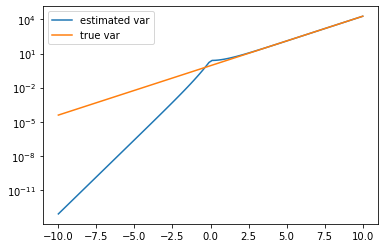

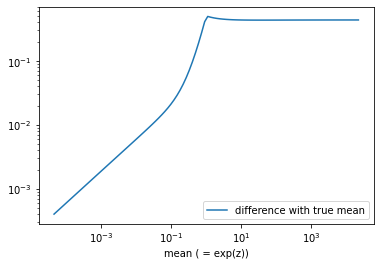

In [292]:
plt.plot(abscisse,try_var, label = 'estimated var')
plt.plot(abscisse, true_var, label = 'true var')
plt.yscale('log')
plt.legend()
plt.show()


plt.plot(np.exp(abscisse),np.abs(np.array(try_mean)-np.array(true_mean)), label = 'difference with true mean')
#plt.plot(abscisse, true_mean, label = 'true mean')
plt.xlabel('mean ( = exp(z))')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


[]

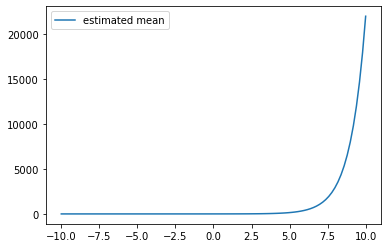

In [191]:
np.exp(z)

162754.79141900392

In [190]:
np.mean(V)

162740.34727348905

In [189]:
np.exp(z)

162754.79141900392

In [188]:
print(np.var(V))

159942.41478299256


In [151]:
print(np.var(np.log(V)))

nan


<ipython-input-151-7ded7fe656fe>:1: RuntimeWarning: invalid value encountered in log
  print(np.var(np.log(V)))


(array([  2.,   2.,  18.,  82., 216., 290., 243., 104.,  35.,   8.]),
 array([11.98950644, 11.9913869 , 11.99326735, 11.99514781, 11.99702826,
        11.99890872, 12.00078918, 12.00266963, 12.00455009, 12.00643055,
        12.008311  ]),
 <BarContainer object of 10 artists>)

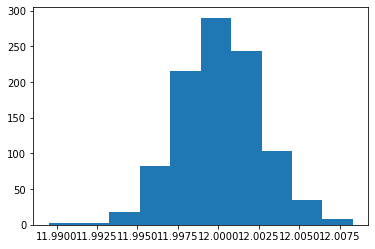

In [107]:
plt.hist(np.log(V))